In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

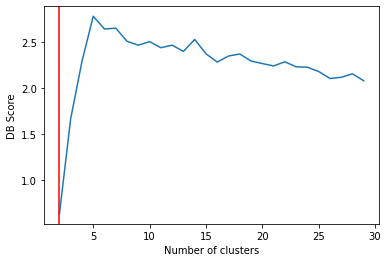

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

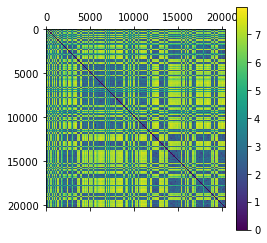

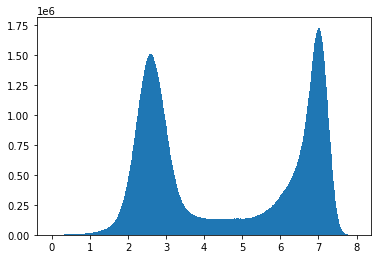

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

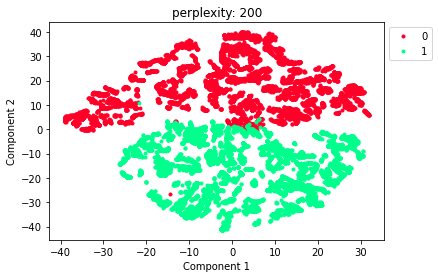

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9982752673335633


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.052405912074420365
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.494475138121547
layer 6: 0.4017610497237569
layer 7: 0.27814226519337015
layer 8: 0.1313449585635359
layer 9: 0.057946305248618796
layer 10: 0.026075837361878452
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.704 | Reg loss: 0.020 | Tree loss: 0.704 | Accuracy: 0.612500 | 34.799 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.699 | Reg loss: 0.019 | Tree loss: 0.699 | Accuracy: 0.551500 | 23.177 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.700 | Reg loss: 0.018 | Tree loss: 0.700 | Accuracy: 0.531500 | 19.361 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.695 | Reg loss: 0.018 | Tree loss: 0.695 | Accuracy: 0.565000 | 17.401 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.693 | Reg loss: 0.017 | Tree loss: 0.693 | Accuracy: 0.583500 | 15.611 sec/iter
Epoch: 00 | Batch: 005 

Epoch: 04 | Batch: 008 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.579000 | 15.428 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.568000 | 15.424 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 0.690 | Reg loss: 0.012 | Tree loss: 0.690 | Accuracy: 0.600683 | 15.227 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.701 | Reg loss: 0.012 | Tree loss: 0.701 | Accuracy: 0.602000 | 16.383 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.701 | Reg loss: 0.012 | Tree loss: 0.701 | Accuracy: 0.606500 | 16.291 sec/iter
Epoch: 05 | Batch: 002 / 01

Epoch: 09 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.011 | Tree loss: 0.693 | Accuracy: 0.607000 | 15.877 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 0.695 | Reg loss: 0.011 | Tree loss: 0.695 | Accuracy: 0.594000 | 15.854 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 0.691 | Reg loss: 0.011 | Tree loss: 0.691 | Accuracy: 0.606500 | 15.817 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 0.695 | Reg loss: 0.011 | Tree loss: 0.695 | Accuracy: 0.563000 | 15.781 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 0.697 | Reg loss: 0.011 | Tree loss: 0.697 | Accuracy: 0.560500 | 15.745 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 0.688 | Reg loss: 0.011 | Tree loss: 0.688 | Accuracy: 0.590444 | 15.637 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 0.698 | Reg loss: 0.010 | Tree loss: 0.698 | Accuracy: 0.667500 | 15.497 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 0.694 | Reg loss: 0.010 | Tree loss: 0.694 | Accuracy: 0.628000 | 15.475 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.010 | Tree loss: 0.692 | Accuracy: 0.600500 | 15.453 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 0.690 | Reg loss: 0.010 | Tree loss: 0.690 | Accuracy: 0.591000 | 15.433 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 0.692 | Reg loss: 0.010 | Tree loss: 0.692 | Accuracy: 0.564000 | 15.41 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 0.689 | Reg loss: 0.010 | Tree loss: 0.689 | Accuracy: 0.567000 | 15.368 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 0.694 | Reg loss: 0.010 | Tree loss: 0.694 | Accuracy: 0.539000 | 15.325 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 0.698 | Reg loss: 0.010 | Tree loss: 0.698 | Accuracy: 0.519500 | 15.283 sec/iter
E

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 0.692 | Reg loss: 0.010 | Tree loss: 0.692 | Accuracy: 0.689000 | 15.567 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 0.689 | Reg loss: 0.010 | Tree loss: 0.689 | Accuracy: 0.689000 | 15.534 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 0.685 | Reg loss: 0.010 | Tree loss: 0.685 | Accuracy: 0.665000 | 15.498 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 0.685 | Reg loss: 0.010 | Tree loss: 0.685 | Accuracy: 0.618000 | 15.462 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 0.677 | Reg loss: 0.010 | Tree loss: 0.677 | Accuracy: 0.595000 | 15.446 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 0.676 | Reg loss: 0.010 | Tree loss: 0.676 | Accuracy: 0.565500 | 15.43 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 0.669 | Reg loss: 0.010 | Tree loss: 0.669 | Accuracy: 0.563000 | 15.414 sec/iter
Epoch: 19 | B

Epoch: 23 | Batch: 010 / 011 | Total loss: 0.665 | Reg loss: 0.011 | Tree loss: 0.665 | Accuracy: 0.638225 | 15.448 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 0.676 | Reg loss: 0.011 | Tree loss: 0.676 | Accuracy: 0.622500 | 15.554 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 0.671 | Reg loss: 0.011 | Tree loss: 0.671 | Accuracy: 0.637000 | 15.527 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 0.663 | Reg loss: 0.011 | Tree loss: 0.663 | Accuracy: 0.632500 | 15.51 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 0.658 | Reg loss: 0.011 | Tree loss: 0.658 | Accuracy: 0.630000 | 15.51 sec/iter
Epoch: 24 | Batch: 004 / 011 

Epoch: 28 | Batch: 007 / 011 | Total loss: 0.626 | Reg loss: 0.012 | Tree loss: 0.626 | Accuracy: 0.701000 | 15.363 sec/iter
Epoch: 28 | Batch: 008 / 011 | Total loss: 0.627 | Reg loss: 0.012 | Tree loss: 0.627 | Accuracy: 0.699500 | 15.353 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 0.627 | Reg loss: 0.012 | Tree loss: 0.627 | Accuracy: 0.698000 | 15.354 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 0.623 | Reg loss: 0.012 | Tree loss: 0.623 | Accuracy: 0.689420 | 15.317 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 0.659 | Reg loss: 0.011 | Tree loss: 0.659 | Accuracy: 0.586000 | 15.435 sec/iter
Epoch: 29 | Batch: 001 / 01

Epoch: 33 | Batch: 004 / 011 | Total loss: 0.607 | Reg loss: 0.013 | Tree loss: 0.607 | Accuracy: 0.693000 | 15.426 sec/iter
Epoch: 33 | Batch: 005 / 011 | Total loss: 0.592 | Reg loss: 0.013 | Tree loss: 0.592 | Accuracy: 0.731000 | 15.418 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 0.586 | Reg loss: 0.014 | Tree loss: 0.586 | Accuracy: 0.743000 | 15.418 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 0.576 | Reg loss: 0.014 | Tree loss: 0.576 | Accuracy: 0.751000 | 15.413 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 0.564 | Reg loss: 0.014 | Tree loss: 0.564 | Accuracy: 0.756000 | 15.404 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 0.582 | Reg loss: 0.014 | Tree loss: 0.582 | Accuracy: 0.698000 | 15.394 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 0.562 | Reg loss: 0.014 | Tree loss: 0.562 | Accuracy: 0.713311 | 15.364 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 38 | Batch: 001 / 011 | Total loss: 0.577 | Reg loss: 0.015 | Tree loss: 0.577 | Accuracy: 0.726500 | 15.42 sec/iter
Epoch: 38 | Batch: 002 / 011 | Total loss: 0.568 | Reg loss: 0.015 | Tree loss: 0.568 | Accuracy: 0.741500 | 15.413 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 0.547 | Reg loss: 0.016 | Tree loss: 0.547 | Accuracy: 0.736500 | 15.406 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 0.547 | Reg loss: 0.016 | Tree loss: 0.547 | Accuracy: 0.735000 | 15.395 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 0.530 | Reg loss: 0.016 | Tree loss: 0.530 | Accuracy: 0.792000 | 15.387 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.528 | Reg loss: 0.016 | Tree loss: 0.528 | Accuracy: 0.822000 | 15.38 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.526 | Reg loss: 0.016 | Tree loss: 0.526 | Accuracy: 0.805500 | 15.373 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.511 | Reg loss: 0.016 | Tree loss: 0.511 | Accuracy: 0.840000 | 15.365 sec/iter
Ep

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 43 | Batch: 000 / 011 | Total loss: 0.565 | Reg loss: 0.017 | Tree loss: 0.565 | Accuracy: 0.709500 | 15.481 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 0.531 | Reg loss: 0.017 | Tree loss: 0.531 | Accuracy: 0.750000 | 15.472 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 0.529 | Reg loss: 0.017 | Tree loss: 0.529 | Accuracy: 0.733000 | 15.461 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 0.534 | Reg loss: 0.017 | Tree loss: 0.534 | Accuracy: 0.731500 | 15.446 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 0.535 | Reg loss: 0.017 | Tree loss: 0.535 | Accuracy: 0.741000 | 15.43 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 0.489 | Reg loss: 0.017 | Tree loss: 0.489 | Accuracy: 0.817000 | 15.41 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 0.485 | Reg loss: 0.017 | Tree loss: 0.4

Epoch: 47 | Batch: 010 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.829352 | 15.406 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 0.545 | Reg loss: 0.017 | Tree loss: 0.545 | Accuracy: 0.726500 | 15.461 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 0.509 | Reg loss: 0.017 | Tree loss: 0.509 | Accuracy: 0.754000 | 15.448 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.765000 | 15.434 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 0.550 | Reg loss: 0.017 | Tree loss: 0.550 | Accuracy: 0.716000 | 15.428 sec/iter
Epoch: 48 | Batch: 004 / 01

Epoch: 52 | Batch: 007 / 011 | Total loss: 0.465 | Reg loss: 0.017 | Tree loss: 0.465 | Accuracy: 0.799500 | 15.385 sec/iter
Epoch: 52 | Batch: 008 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.834500 | 15.375 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 0.465 | Reg loss: 0.018 | Tree loss: 0.465 | Accuracy: 0.834500 | 15.363 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 0.476 | Reg loss: 0.018 | Tree loss: 0.476 | Accuracy: 0.853242 | 15.344 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 0.543 | Reg loss: 0.017 | Tree loss: 0.543 | Accuracy: 0.743500 | 15.426 sec/iter
Epoch: 53 | Batch: 001 / 01

Epoch: 57 | Batch: 004 / 011 | Total loss: 0.469 | Reg loss: 0.018 | Tree loss: 0.469 | Accuracy: 0.793500 | 15.463 sec/iter
Epoch: 57 | Batch: 005 / 011 | Total loss: 0.479 | Reg loss: 0.018 | Tree loss: 0.479 | Accuracy: 0.790500 | 15.458 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 0.470 | Reg loss: 0.018 | Tree loss: 0.470 | Accuracy: 0.792500 | 15.454 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.018 | Tree loss: 0.483 | Accuracy: 0.780000 | 15.451 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 0.440 | Reg loss: 0.018 | Tree loss: 0.440 | Accuracy: 0.815000 | 15.452 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 0.450 | Reg loss: 0.018 | Tree loss: 0.450 | Accuracy: 0.843000 | 15.452 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 0.472 | Reg loss: 0.018 | Tree loss: 0.472 | Accuracy: 0.808874 | 15.436 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 62 | Batch: 001 / 011 | Total loss: 0.517 | Reg loss: 0.018 | Tree loss: 0.517 | Accuracy: 0.774000 | 15.412 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.018 | Tree loss: 0.507 | Accuracy: 0.768000 | 15.412 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.018 | Tree loss: 0.480 | Accuracy: 0.795500 | 15.412 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.463 | Reg loss: 0.018 | Tree loss: 0.463 | Accuracy: 0.823000 | 15.412 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.018 | Tree loss: 0.448 | Accuracy: 0.814500 | 15.412 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 0.460 | Reg loss: 0.018 | Tree loss: 0.460 | Accuracy: 0.800000 | 15.408 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 0.470 | Reg loss: 0.018 | Tree loss: 0.470 | Accuracy: 0.787500 | 15.403 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 0.468 | Reg loss: 0.018 | Tree loss: 0.468 | Accuracy: 0.789500 | 15.398 sec/iter


layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.537 | Reg loss: 0.018 | Tree loss: 0.537 | Accuracy: 0.744500 | 15.465 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.523 | Reg loss: 0.018 | Tree loss: 0.523 | Accuracy: 0.754000 | 15.46 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.495 | Reg loss: 0.018 | Tree loss: 0.495 | Accuracy: 0.773000 | 15.455 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.469 | Reg loss: 0.018 | Tree loss: 0.469 | Accuracy: 0.790500 | 15.45 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.440 | Reg loss: 0.018 | Tree loss: 0.440 | Accuracy: 0.846500 | 15.442 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.461 | Reg loss: 0.018 | Tree loss: 0.461 | Accuracy: 0.800500 | 15.434 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.470 | Reg loss: 0.018 | Tree loss: 0.4

Epoch: 71 | Batch: 010 / 011 | Total loss: 0.436 | Reg loss: 0.018 | Tree loss: 0.436 | Accuracy: 0.802048 | 15.36 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 0.515 | Reg loss: 0.018 | Tree loss: 0.515 | Accuracy: 0.755000 | 15.41 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 0.515 | Reg loss: 0.018 | Tree loss: 0.515 | Accuracy: 0.762000 | 15.406 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 0.484 | Reg loss: 0.018 | Tree loss: 0.484 | Accuracy: 0.779500 | 15.401 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.466 | Reg loss: 0.018 | Tree loss: 0.466 | Accuracy: 0.798000 | 15.397 sec/iter
Epoch: 72 | Batch: 004 / 011 

Epoch: 76 | Batch: 007 / 011 | Total loss: 0.465 | Reg loss: 0.019 | Tree loss: 0.465 | Accuracy: 0.786500 | 15.425 sec/iter
Epoch: 76 | Batch: 008 / 011 | Total loss: 0.445 | Reg loss: 0.019 | Tree loss: 0.445 | Accuracy: 0.792000 | 15.425 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.452 | Reg loss: 0.019 | Tree loss: 0.452 | Accuracy: 0.794500 | 15.426 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.433 | Reg loss: 0.019 | Tree loss: 0.433 | Accuracy: 0.802048 | 15.413 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.019 | Tree loss: 0.505 | Accuracy: 0.761000 | 15.468 sec/iter
Epoch: 77 | Batch: 001 / 01

Epoch: 81 | Batch: 004 / 011 | Total loss: 0.440 | Reg loss: 0.019 | Tree loss: 0.440 | Accuracy: 0.827000 | 15.415 sec/iter
Epoch: 81 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.019 | Tree loss: 0.445 | Accuracy: 0.803500 | 15.416 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.019 | Tree loss: 0.448 | Accuracy: 0.807000 | 15.416 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.019 | Tree loss: 0.444 | Accuracy: 0.801000 | 15.417 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 0.450 | Reg loss: 0.019 | Tree loss: 0.450 | Accuracy: 0.790500 | 15.417 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 0.435 | Reg loss: 0.019 | Tree loss: 0.435 | Accuracy: 0.807500 | 15.414 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 0.424 | Reg loss: 0.019 | Tree loss: 0.424 | Accuracy: 0.843003 | 15.401 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 86 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.019 | Tree loss: 0.491 | Accuracy: 0.773000 | 15.396 sec/iter
Epoch: 86 | Batch: 002 / 011 | Total loss: 0.472 | Reg loss: 0.019 | Tree loss: 0.472 | Accuracy: 0.789500 | 15.396 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.019 | Tree loss: 0.449 | Accuracy: 0.809000 | 15.393 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 0.445 | Reg loss: 0.019 | Tree loss: 0.445 | Accuracy: 0.821500 | 15.389 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 0.429 | Reg loss: 0.019 | Tree loss: 0.429 | Accuracy: 0.821500 | 15.385 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.019 | Tree loss: 0.446 | Accuracy: 0.808500 | 15.381 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 0.454 | Reg loss: 0.019 | Tree loss: 0.454 | Accuracy: 0.790500 | 15.375 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.448 | Reg loss: 0.019 | Tree loss: 0.448 | Accuracy: 0.797500 | 15.367 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 91 | Batch: 000 / 011 | Total loss: 0.479 | Reg loss: 0.019 | Tree loss: 0.479 | Accuracy: 0.779500 | 15.463 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.019 | Tree loss: 0.483 | Accuracy: 0.772000 | 15.456 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.019 | Tree loss: 0.491 | Accuracy: 0.788500 | 15.453 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.019 | Tree loss: 0.447 | Accuracy: 0.815000 | 15.449 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 0.439 | Reg loss: 0.019 | Tree loss: 0.439 | Accuracy: 0.826500 | 15.445 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.019 | Tree loss: 0.425 | Accuracy: 0.817000 | 15.441 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.019 | Tree loss: 0.446 | Accuracy: 0.805500 | 15.439 sec/iter
Epoch: 91 | 

Epoch: 95 | Batch: 010 / 011 | Total loss: 0.399 | Reg loss: 0.019 | Tree loss: 0.399 | Accuracy: 0.863481 | 15.419 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.019 | Tree loss: 0.472 | Accuracy: 0.784500 | 15.44 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.019 | Tree loss: 0.486 | Accuracy: 0.779000 | 15.437 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.019 | Tree loss: 0.473 | Accuracy: 0.786500 | 15.435 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 0.438 | Reg loss: 0.019 | Tree loss: 0.438 | Accuracy: 0.809500 | 15.436 sec/iter
Epoch: 96 | Batch: 004 / 011

Epoch: 100 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.019 | Tree loss: 0.435 | Accuracy: 0.807500 | 15.461 sec/iter
Epoch: 100 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.019 | Tree loss: 0.432 | Accuracy: 0.808000 | 15.461 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 0.418 | Reg loss: 0.019 | Tree loss: 0.418 | Accuracy: 0.813000 | 15.462 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 0.404 | Reg loss: 0.019 | Tree loss: 0.404 | Accuracy: 0.890785 | 15.452 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.019 | Tree loss: 0.483 | Accuracy: 0.787500 | 15.492 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.019 | Tree loss: 0.418 | Accuracy: 0.829000 | 15.451 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.019 | Tree loss: 0.425 | Accuracy: 0.814000 | 15.448 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.452 | Reg loss: 0.019 | Tree loss: 0.452 | Accuracy: 0.789000 | 15.446 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.019 | Tree loss: 0.430 | Accuracy: 0.802000 | 15.44 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 0.434 | Reg loss: 0.019 | Tree loss: 0.434 | Accuracy: 0.804000 | 15.437 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.423 | Reg loss: 0.019 | Tree loss: 0.423 | Accuracy: 0.811000 | 15.434 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.429 | Reg loss: 0.019 | Tree loss: 0.429 | Accuracy: 0.815700 | 15.424 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 110 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.019 | Tree loss: 0.475 | Accuracy: 0.779000 | 15.447 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.470 | Reg loss: 0.019 | Tree loss: 0.470 | Accuracy: 0.782000 | 15.445 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.019 | Tree loss: 0.424 | Accuracy: 0.830000 | 15.442 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.019 | Tree loss: 0.412 | Accuracy: 0.846500 | 15.44 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.432 | Reg loss: 0.019 | Tree loss: 0.432 | Accuracy: 0.799000 | 15.435 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.019 | Tree loss: 0.444 | Accuracy: 0.800500 | 15.428 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.019 | Tree loss: 0.427 | Accuracy: 0.802000 | 15.422 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.436 | Reg loss: 0.019 | Tree loss: 0.436 | Accuracy: 0.805000 | 15.416 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.482 | Reg loss: 0.019 | Tree loss: 0.482 | Accuracy: 0.775500 | 15.471 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.019 | Tree loss: 0.486 | Accuracy: 0.768500 | 15.469 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.463 | Reg loss: 0.019 | Tree loss: 0.463 | Accuracy: 0.799000 | 15.466 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.439 | Reg loss: 0.019 | Tree loss: 0.439 | Accuracy: 0.821500 | 15.465 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.423 | Reg loss: 0.019 | Tree loss: 0.423 | Accuracy: 0.820000 | 15.462 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.019 | Tree loss: 0.428 | Accuracy: 0.805500 | 15.46 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.445 | Reg loss: 0.019 | Tree loss: 0.445 | Accuracy: 0.794500 | 15.457 sec/iter
Epoch: 115 | Batch: 007 / 011 | To

Epoch: 119 | Batch: 010 / 011 | Total loss: 0.404 | Reg loss: 0.019 | Tree loss: 0.404 | Accuracy: 0.839590 | 15.41 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.458 | Reg loss: 0.019 | Tree loss: 0.458 | Accuracy: 0.791500 | 15.429 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.019 | Tree loss: 0.472 | Accuracy: 0.777000 | 15.427 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.019 | Tree loss: 0.447 | Accuracy: 0.799500 | 15.424 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.019 | Tree loss: 0.431 | Accuracy: 0.819500 | 15.422 sec/iter
Epoch: 120 | Batch: 004

Epoch: 124 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.019 | Tree loss: 0.437 | Accuracy: 0.801500 | 15.423 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.416 | Reg loss: 0.019 | Tree loss: 0.416 | Accuracy: 0.808000 | 15.423 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.411 | Reg loss: 0.019 | Tree loss: 0.411 | Accuracy: 0.814000 | 15.424 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.425 | Reg loss: 0.019 | Tree loss: 0.425 | Accuracy: 0.849829 | 15.416 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.019 | Tree loss: 0.469 | Accuracy: 0.786000 | 15.467 sec/iter
Epoch: 125 | Batch: 00

Epoch: 129 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.019 | Tree loss: 0.419 | Accuracy: 0.829000 | 15.436 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.019 | Tree loss: 0.412 | Accuracy: 0.819500 | 15.434 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.019 | Tree loss: 0.414 | Accuracy: 0.821000 | 15.431 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.019 | Tree loss: 0.430 | Accuracy: 0.798500 | 15.426 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.447 | Reg loss: 0.019 | Tree loss: 0.447 | Accuracy: 0.780000 | 15.424 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.438 | Reg loss: 0.019 | Tree loss: 0.438 | Accuracy: 0.798000 | 15.422 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.381 | Reg loss: 0.019 | Tree loss: 0.381 | Accuracy: 0.846416 | 15.413 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 134 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.019 | Tree loss: 0.499 | Accuracy: 0.757500 | 15.454 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.454 | Reg loss: 0.019 | Tree loss: 0.454 | Accuracy: 0.810000 | 15.45 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.426 | Reg loss: 0.019 | Tree loss: 0.426 | Accuracy: 0.814500 | 15.445 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.019 | Tree loss: 0.415 | Accuracy: 0.840000 | 15.44 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.019 | Tree loss: 0.396 | Accuracy: 0.831000 | 15.435 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.020 | Tree loss: 0.428 | Accuracy: 0.807000 | 15.432 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.447 | Reg loss: 0.020 | Tree loss: 0.447 | Accuracy: 0.791500 | 15.43 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.793500 | 15.428 sec/

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 139 | Batch: 000 / 011 | Total loss: 0.465 | Reg loss: 0.020 | Tree loss: 0.465 | Accuracy: 0.791000 | 15.435 sec/iter
Epoch: 139 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.020 | Tree loss: 0.472 | Accuracy: 0.786500 | 15.435 sec/iter
Epoch: 139 | Batch: 002 / 011 | Total loss: 0.470 | Reg loss: 0.020 | Tree loss: 0.470 | Accuracy: 0.779000 | 15.435 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.419 | Reg loss: 0.020 | Tree loss: 0.419 | Accuracy: 0.821000 | 15.436 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.832500 | 15.434 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.820000 | 15.432 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.807500 | 15.43 sec/iter
Epoch: 139 | Batch: 007 / 011 | To

Epoch: 143 | Batch: 010 / 011 | Total loss: 0.408 | Reg loss: 0.020 | Tree loss: 0.408 | Accuracy: 0.815700 | 15.428 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 0.458 | Reg loss: 0.020 | Tree loss: 0.458 | Accuracy: 0.795500 | 15.473 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.020 | Tree loss: 0.467 | Accuracy: 0.782000 | 15.469 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.020 | Tree loss: 0.459 | Accuracy: 0.792500 | 15.465 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.020 | Tree loss: 0.430 | Accuracy: 0.815500 | 15.461 sec/iter
Epoch: 144 | Batch: 00

Epoch: 148 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.020 | Tree loss: 0.433 | Accuracy: 0.790500 | 15.456 sec/iter
Epoch: 148 | Batch: 008 / 011 | Total loss: 0.417 | Reg loss: 0.020 | Tree loss: 0.417 | Accuracy: 0.806000 | 15.454 sec/iter
Epoch: 148 | Batch: 009 / 011 | Total loss: 0.424 | Reg loss: 0.020 | Tree loss: 0.424 | Accuracy: 0.809500 | 15.452 sec/iter
Epoch: 148 | Batch: 010 / 011 | Total loss: 0.379 | Reg loss: 0.020 | Tree loss: 0.379 | Accuracy: 0.846416 | 15.445 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 0.464 | Reg loss: 0.020 | Tree loss: 0.464 | Accuracy: 0.791000 | 15.464 sec/iter
Epoch: 149 | Batch: 00

Epoch: 153 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.020 | Tree loss: 0.395 | Accuracy: 0.844000 | 15.444 sec/iter
Epoch: 153 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.828000 | 15.44 sec/iter
Epoch: 153 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.020 | Tree loss: 0.411 | Accuracy: 0.817500 | 15.436 sec/iter
Epoch: 153 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.020 | Tree loss: 0.430 | Accuracy: 0.794500 | 15.432 sec/iter
Epoch: 153 | Batch: 008 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.811000 | 15.427 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 0.407 | Reg loss: 0.020 | Tree loss: 0.407 | Accuracy: 0.814000 | 15.422 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 0.415 | Reg loss: 0.020 | Tree loss: 0.415 | Accuracy: 0.849829 | 15.415 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 158 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.020 | Tree loss: 0.488 | Accuracy: 0.767000 | 15.456 sec/iter
Epoch: 158 | Batch: 002 / 011 | Total loss: 0.479 | Reg loss: 0.020 | Tree loss: 0.479 | Accuracy: 0.776500 | 15.454 sec/iter
Epoch: 158 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.810000 | 15.45 sec/iter
Epoch: 158 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.020 | Tree loss: 0.411 | Accuracy: 0.833500 | 15.447 sec/iter
Epoch: 158 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.020 | Tree loss: 0.410 | Accuracy: 0.852000 | 15.443 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.020 | Tree loss: 0.416 | Accuracy: 0.815000 | 15.44 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.020 | Tree loss: 0.422 | Accuracy: 0.807500 | 15.437 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 0.411 | Reg loss: 0.020 | Tree loss: 0.411 | Accuracy: 0.809000 | 15.433 sec

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 163 | Batch: 000 / 011 | Total loss: 0.456 | Reg loss: 0.020 | Tree loss: 0.456 | Accuracy: 0.793000 | 15.457 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.020 | Tree loss: 0.479 | Accuracy: 0.784000 | 15.453 sec/iter
Epoch: 163 | Batch: 002 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.813000 | 15.449 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 0.421 | Reg loss: 0.020 | Tree loss: 0.421 | Accuracy: 0.817000 | 15.447 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.020 | Tree loss: 0.393 | Accuracy: 0.849500 | 15.445 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.020 | Tree loss: 0.407 | Accuracy: 0.819500 | 15.445 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.80

Epoch: 167 | Batch: 009 / 011 | Total loss: 0.410 | Reg loss: 0.020 | Tree loss: 0.410 | Accuracy: 0.816500 | 15.429 sec/iter
Epoch: 167 | Batch: 010 / 011 | Total loss: 0.402 | Reg loss: 0.020 | Tree loss: 0.402 | Accuracy: 0.836177 | 15.422 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 168 | Batch: 000 / 011 | Total loss: 0.450 | Reg loss: 0.020 | Tree loss: 0.450 | Accuracy: 0.804500 | 15.439 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.020 | Tree loss: 0.466 | Accuracy: 0.784000 | 15.437 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 0.453 | Reg loss: 0.020 | Tree loss: 0.453 | Accuracy: 0.800000 | 15.436 sec/iter
Epoch: 168 | Batch: 00

Epoch: 172 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.808500 | 15.434 sec/iter
Epoch: 172 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.020 | Tree loss: 0.442 | Accuracy: 0.792500 | 15.431 sec/iter
Epoch: 172 | Batch: 008 / 011 | Total loss: 0.421 | Reg loss: 0.020 | Tree loss: 0.421 | Accuracy: 0.801500 | 15.429 sec/iter
Epoch: 172 | Batch: 009 / 011 | Total loss: 0.404 | Reg loss: 0.020 | Tree loss: 0.404 | Accuracy: 0.818000 | 15.427 sec/iter
Epoch: 172 | Batch: 010 / 011 | Total loss: 0.397 | Reg loss: 0.020 | Tree loss: 0.397 | Accuracy: 0.846416 | 15.421 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 00

Epoch: 177 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.796500 | 15.444 sec/iter
Epoch: 177 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.020 | Tree loss: 0.399 | Accuracy: 0.829500 | 15.443 sec/iter
Epoch: 177 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.020 | Tree loss: 0.397 | Accuracy: 0.836500 | 15.444 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.020 | Tree loss: 0.421 | Accuracy: 0.811500 | 15.444 sec/iter
Epoch: 177 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.020 | Tree loss: 0.444 | Accuracy: 0.784500 | 15.444 sec/iter
Epoch: 177 | Batch: 008 / 011 | Total loss: 0.413 | Reg loss: 0.020 | Tree loss: 0.413 | Accuracy: 0.805000 | 15.442 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.413 | Reg loss: 0.020 | Tree loss: 0.413 | Accuracy: 0.804000 | 15.44 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.020 | Tree loss: 0.392 | Accuracy: 0.853242 | 15.435 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 182 | Batch: 000 / 011 | Total loss: 0.447 | Reg loss: 0.020 | Tree loss: 0.447 | Accuracy: 0.796500 | 15.435 sec/iter
Epoch: 182 | Batch: 001 / 011 | Total loss: 0.441 | Reg loss: 0.020 | Tree loss: 0.441 | Accuracy: 0.804500 | 15.435 sec/iter
Epoch: 182 | Batch: 002 / 011 | Total loss: 0.438 | Reg loss: 0.020 | Tree loss: 0.438 | Accuracy: 0.806000 | 15.435 sec/iter
Epoch: 182 | Batch: 003 / 011 | Total loss: 0.427 | Reg loss: 0.020 | Tree loss: 0.427 | Accuracy: 0.816000 | 15.434 sec/iter
Epoch: 182 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.020 | Tree loss: 0.391 | Accuracy: 0.858000 | 15.433 sec/iter
Epoch: 182 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.020 | Tree loss: 0.403 | Accuracy: 0.821000 | 15.431 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.811000 | 15.428 sec/iter
Epoch: 182 | Batch: 007 / 011 | T

Epoch: 186 | Batch: 010 / 011 | Total loss: 0.373 | Reg loss: 0.020 | Tree loss: 0.373 | Accuracy: 0.873720 | 15.441 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 187 | Batch: 000 / 011 | Total loss: 0.443 | Reg loss: 0.020 | Tree loss: 0.443 | Accuracy: 0.791000 | 15.452 sec/iter
Epoch: 187 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.020 | Tree loss: 0.446 | Accuracy: 0.791000 | 15.45 sec/iter
Epoch: 187 | Batch: 002 / 011 | Total loss: 0.440 | Reg loss: 0.020 | Tree loss: 0.440 | Accuracy: 0.811500 | 15.448 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 0.414 | Reg loss: 0.020 | Tree loss: 0.414 | Accuracy: 0.827000 | 15.446 sec/iter
Epoch: 187 | Batch: 004

Epoch: 191 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.020 | Tree loss: 0.417 | Accuracy: 0.805500 | 15.428 sec/iter
Epoch: 191 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.020 | Tree loss: 0.415 | Accuracy: 0.801000 | 15.425 sec/iter
Epoch: 191 | Batch: 009 / 011 | Total loss: 0.401 | Reg loss: 0.020 | Tree loss: 0.401 | Accuracy: 0.820500 | 15.422 sec/iter
Epoch: 191 | Batch: 010 / 011 | Total loss: 0.380 | Reg loss: 0.020 | Tree loss: 0.380 | Accuracy: 0.860068 | 15.416 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 0.443 | Reg loss: 0.020 | Tree loss: 0.443 | Accuracy: 0.793500 | 15.439 sec/iter
Epoch: 192 | Batch: 00

Epoch: 196 | Batch: 004 / 011 | Total loss: 0.392 | Reg loss: 0.020 | Tree loss: 0.392 | Accuracy: 0.859500 | 15.445 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.020 | Tree loss: 0.402 | Accuracy: 0.821500 | 15.441 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.794000 | 15.439 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.788500 | 15.437 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.419 | Reg loss: 0.020 | Tree loss: 0.419 | Accuracy: 0.802000 | 15.435 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.407 | Reg loss: 0.020 | Tree loss: 0.407 | Accuracy: 0.817000 | 15.433 sec/iter
Epoch: 196 | Batch: 010 / 011 | Total loss: 0.384 | Reg loss: 0.020 | Tree loss: 0.384 | Accuracy: 0.856655 | 15.428 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 201 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.020 | Tree loss: 0.474 | Accuracy: 0.772500 | 15.414 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.419 | Reg loss: 0.020 | Tree loss: 0.419 | Accuracy: 0.819500 | 15.411 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.415 | Reg loss: 0.020 | Tree loss: 0.415 | Accuracy: 0.827500 | 15.407 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.020 | Tree loss: 0.404 | Accuracy: 0.857000 | 15.404 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.020 | Tree loss: 0.390 | Accuracy: 0.844000 | 15.401 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.020 | Tree loss: 0.404 | Accuracy: 0.808000 | 15.398 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.020 | Tree loss: 0.414 | Accuracy: 0.806500 | 15.396 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.409 | Reg loss: 0.020 | Tree loss: 0.409 | Accuracy: 0.810500 | 15.395 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 206 | Batch: 000 / 011 | Total loss: 0.446 | Reg loss: 0.020 | Tree loss: 0.446 | Accuracy: 0.795000 | 15.279 sec/iter
Epoch: 206 | Batch: 001 / 011 | Total loss: 0.457 | Reg loss: 0.020 | Tree loss: 0.457 | Accuracy: 0.788000 | 15.276 sec/iter
Epoch: 206 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.020 | Tree loss: 0.448 | Accuracy: 0.804000 | 15.272 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.020 | Tree loss: 0.402 | Accuracy: 0.832500 | 15.267 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.020 | Tree loss: 0.383 | Accuracy: 0.855500 | 15.265 sec/iter
Epoch: 206 | Batch: 00

Epoch: 210 | Batch: 008 / 011 | Total loss: 0.404 | Reg loss: 0.020 | Tree loss: 0.404 | Accuracy: 0.822500 | 15.117 sec/iter
Epoch: 210 | Batch: 009 / 011 | Total loss: 0.404 | Reg loss: 0.020 | Tree loss: 0.404 | Accuracy: 0.828000 | 15.114 sec/iter
Epoch: 210 | Batch: 010 / 011 | Total loss: 0.377 | Reg loss: 0.020 | Tree loss: 0.377 | Accuracy: 0.866894 | 15.109 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 211 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.020 | Tree loss: 0.474 | Accuracy: 0.767500 | 15.109 sec/iter
Epoch: 211 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.020 | Tree loss: 0.447 | Accuracy: 0.801500 | 15.106 sec/iter
Epoch: 211 | Batch: 00

Epoch: 215 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.020 | Tree loss: 0.401 | Accuracy: 0.819500 | 14.963 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.020 | Tree loss: 0.412 | Accuracy: 0.804000 | 14.96 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.020 | Tree loss: 0.413 | Accuracy: 0.805500 | 14.958 sec/iter
Epoch: 215 | Batch: 008 / 011 | Total loss: 0.400 | Reg loss: 0.020 | Tree loss: 0.400 | Accuracy: 0.813000 | 14.955 sec/iter
Epoch: 215 | Batch: 009 / 011 | Total loss: 0.401 | Reg loss: 0.020 | Tree loss: 0.401 | Accuracy: 0.823000 | 14.952 sec/iter
Epoch: 215 | Batch: 010 / 011 | Total loss: 0.391 | Reg loss: 0.020 | Tree loss: 0.391 | Accuracy: 0.832765 | 14.947 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 220 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.020 | Tree loss: 0.441 | Accuracy: 0.811000 | 14.818 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 0.406 | Reg loss: 0.020 | Tree loss: 0.406 | Accuracy: 0.824000 | 14.814 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.020 | Tree loss: 0.389 | Accuracy: 0.851000 | 14.811 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.020 | Tree loss: 0.386 | Accuracy: 0.838000 | 14.809 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.020 | Tree loss: 0.403 | Accuracy: 0.816500 | 14.806 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.411 | Reg loss: 0.020 | Tree loss: 0.411 | Accuracy: 0.806000 | 14.803 sec/iter
Epoch: 220 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.788000 | 14.801 sec/iter
Epoch: 220 | Batch: 009 / 011 | Total loss: 0.413 | Reg loss: 0.021 | Tree loss: 0.413 | Accuracy: 0.800500 | 14.798 s

layer 10: 0.9723756906077345
Epoch: 225 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.021 | Tree loss: 0.467 | Accuracy: 0.784500 | 14.675 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.442 | Reg loss: 0.021 | Tree loss: 0.442 | Accuracy: 0.793500 | 14.673 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.021 | Tree loss: 0.427 | Accuracy: 0.824000 | 14.669 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.828500 | 14.665 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.846000 | 14.663 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.021 | Tree loss: 0.389 | Accuracy: 0.851000 | 14.661 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.812500 | 14.658 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.021 | Tree loss: 0.397 | 

Epoch: 229 | Batch: 010 / 011 | Total loss: 0.397 | Reg loss: 0.021 | Tree loss: 0.397 | Accuracy: 0.839590 | 14.534 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 230 | Batch: 000 / 011 | Total loss: 0.454 | Reg loss: 0.021 | Tree loss: 0.454 | Accuracy: 0.781500 | 14.534 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.021 | Tree loss: 0.447 | Accuracy: 0.801000 | 14.531 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.021 | Tree loss: 0.448 | Accuracy: 0.792000 | 14.528 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.021 | Tree loss: 0.422 | Accuracy: 0.824000 | 14.524 sec/iter
Epoch: 230 | Batch: 00

Epoch: 234 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.798500 | 14.407 sec/iter
Epoch: 234 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.784500 | 14.404 sec/iter
Epoch: 234 | Batch: 009 / 011 | Total loss: 0.406 | Reg loss: 0.021 | Tree loss: 0.406 | Accuracy: 0.802000 | 14.402 sec/iter
Epoch: 234 | Batch: 010 / 011 | Total loss: 0.362 | Reg loss: 0.021 | Tree loss: 0.362 | Accuracy: 0.856655 | 14.397 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 235 | Batch: 000 / 011 | Total loss: 0.451 | Reg loss: 0.021 | Tree loss: 0.451 | Accuracy: 0.794500 | 14.398 sec/iter
Epoch: 235 | Batch: 00

Epoch: 239 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.021 | Tree loss: 0.391 | Accuracy: 0.863500 | 14.284 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.021 | Tree loss: 0.401 | Accuracy: 0.837500 | 14.282 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.021 | Tree loss: 0.406 | Accuracy: 0.806000 | 14.279 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.809000 | 14.277 sec/iter
Epoch: 239 | Batch: 008 / 011 | Total loss: 0.407 | Reg loss: 0.021 | Tree loss: 0.407 | Accuracy: 0.807500 | 14.275 sec/iter
Epoch: 239 | Batch: 009 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.815500 | 14.273 sec/iter
Epoch: 239 | Batch: 010 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.829352 | 14.269 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 244 | Batch: 001 / 011 | Total loss: 0.449 | Reg loss: 0.021 | Tree loss: 0.449 | Accuracy: 0.800000 | 14.168 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 0.431 | Reg loss: 0.021 | Tree loss: 0.431 | Accuracy: 0.811000 | 14.165 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.826000 | 14.162 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.398 | Reg loss: 0.021 | Tree loss: 0.398 | Accuracy: 0.847000 | 14.16 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.021 | Tree loss: 0.391 | Accuracy: 0.848000 | 14.157 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.021 | Tree loss: 0.390 | Accuracy: 0.819500 | 14.155 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.801000 | 14.153 sec/iter
Epoch: 244 | Batch: 008 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.794500 | 14.151 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 249 | Batch: 000 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.810500 | 14.049 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.799000 | 14.047 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy: 0.813000 | 14.044 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.836000 | 14.041 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.021 | Tree loss: 0.395 | Accuracy: 0.833500 | 14.039 sec/iter
Epoch: 249 | Batch: 00

Epoch: 253 | Batch: 008 / 011 | Total loss: 0.414 | Reg loss: 0.021 | Tree loss: 0.414 | Accuracy: 0.798500 | 13.936 sec/iter
Epoch: 253 | Batch: 009 / 011 | Total loss: 0.402 | Reg loss: 0.021 | Tree loss: 0.402 | Accuracy: 0.831000 | 13.934 sec/iter
Epoch: 253 | Batch: 010 / 011 | Total loss: 0.399 | Reg loss: 0.021 | Tree loss: 0.399 | Accuracy: 0.836177 | 13.931 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 254 | Batch: 000 / 011 | Total loss: 0.454 | Reg loss: 0.021 | Tree loss: 0.454 | Accuracy: 0.792000 | 13.931 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.801000 | 13.929 sec/iter
Epoch: 254 | Batch: 00

Epoch: 258 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.021 | Tree loss: 0.394 | Accuracy: 0.834000 | 13.828 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.021 | Tree loss: 0.394 | Accuracy: 0.821500 | 13.826 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.800500 | 13.824 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.811000 | 13.822 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.815000 | 13.82 sec/iter
Epoch: 258 | Batch: 010 / 011 | Total loss: 0.371 | Reg loss: 0.021 | Tree loss: 0.371 | Accuracy: 0.866894 | 13.817 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 263 | Batch: 002 / 011 | Total loss: 0.436 | Reg loss: 0.021 | Tree loss: 0.436 | Accuracy: 0.818000 | 13.727 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.021 | Tree loss: 0.395 | Accuracy: 0.842000 | 13.726 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.865000 | 13.724 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.021 | Tree loss: 0.382 | Accuracy: 0.833000 | 13.722 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.021 | Tree loss: 0.398 | Accuracy: 0.818000 | 13.72 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.801000 | 13.719 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.803500 | 13.717 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.021 | Tree loss: 0.388 | Accuracy: 0.831000 | 13.715 se

Epoch: 268 | Batch: 000 / 011 | Total loss: 0.435 | Reg loss: 0.021 | Tree loss: 0.435 | Accuracy: 0.800000 | 13.631 sec/iter
Epoch: 268 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.021 | Tree loss: 0.428 | Accuracy: 0.803500 | 13.629 sec/iter
Epoch: 268 | Batch: 002 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.816000 | 13.626 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 0.406 | Reg loss: 0.021 | Tree loss: 0.406 | Accuracy: 0.821500 | 13.625 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.021 | Tree loss: 0.388 | Accuracy: 0.848500 | 13.623 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.021 | Tree loss: 0.390 | Accuracy: 0.863000 | 13.621 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.021 | Tree loss: 0.398 | Accuracy: 0.809000 | 13.619 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.805500 | 13.618 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 273 | Batch: 000 / 011 | Total loss: 0.440 | Reg loss: 0.021 | Tree loss: 0.440 | Accuracy: 0.801000 | 13.529 sec/iter
Epoch: 273 | Batch: 001 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.803000 | 13.527 sec/iter
Epoch: 273 | Batch: 002 / 011 | Total loss: 0.420 | Reg loss: 0.021 | Tree loss: 0.420 | Accuracy: 0.817000 | 13.526 sec/iter
Epoch: 273 | Batch: 003 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.819000 | 13.523 sec/iter
Epoch: 273 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.872500 | 13.521 sec/iter
Epoch: 273 | Batch: 00

Epoch: 277 | Batch: 008 / 011 | Total loss: 0.407 | Reg loss: 0.021 | Tree loss: 0.407 | Accuracy: 0.802000 | 13.438 sec/iter
Epoch: 277 | Batch: 009 / 011 | Total loss: 0.390 | Reg loss: 0.021 | Tree loss: 0.390 | Accuracy: 0.827000 | 13.436 sec/iter
Epoch: 277 | Batch: 010 / 011 | Total loss: 0.387 | Reg loss: 0.021 | Tree loss: 0.387 | Accuracy: 0.836177 | 13.433 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 278 | Batch: 000 / 011 | Total loss: 0.444 | Reg loss: 0.021 | Tree loss: 0.444 | Accuracy: 0.791500 | 13.434 sec/iter
Epoch: 278 | Batch: 001 / 011 | Total loss: 0.456 | Reg loss: 0.021 | Tree loss: 0.456 | Accuracy: 0.796000 | 13.432 sec/iter
Epoch: 278 | Batch: 00

Epoch: 282 | Batch: 005 / 011 | Total loss: 0.385 | Reg loss: 0.021 | Tree loss: 0.385 | Accuracy: 0.855000 | 13.348 sec/iter
Epoch: 282 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.021 | Tree loss: 0.400 | Accuracy: 0.810500 | 13.347 sec/iter
Epoch: 282 | Batch: 007 / 011 | Total loss: 0.411 | Reg loss: 0.021 | Tree loss: 0.411 | Accuracy: 0.801000 | 13.345 sec/iter
Epoch: 282 | Batch: 008 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.796500 | 13.344 sec/iter
Epoch: 282 | Batch: 009 / 011 | Total loss: 0.393 | Reg loss: 0.021 | Tree loss: 0.393 | Accuracy: 0.821500 | 13.342 sec/iter
Epoch: 282 | Batch: 010 / 011 | Total loss: 0.380 | Reg loss: 0.021 | Tree loss: 0.380 | Accuracy: 0.870307 | 13.34 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 287 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.021 | Tree loss: 0.427 | Accuracy: 0.816500 | 13.262 sec/iter
Epoch: 287 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.021 | Tree loss: 0.402 | Accuracy: 0.829000 | 13.26 sec/iter
Epoch: 287 | Batch: 004 / 011 | Total loss: 0.401 | Reg loss: 0.021 | Tree loss: 0.401 | Accuracy: 0.840000 | 13.259 sec/iter
Epoch: 287 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.021 | Tree loss: 0.395 | Accuracy: 0.851000 | 13.257 sec/iter
Epoch: 287 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.021 | Tree loss: 0.401 | Accuracy: 0.811500 | 13.255 sec/iter
Epoch: 287 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.021 | Tree loss: 0.401 | Accuracy: 0.811000 | 13.253 sec/iter
Epoch: 287 | Batch: 008 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.801500 | 13.251 sec/iter
Epoch: 287 | Batch: 009 / 011 | Total loss: 0.393 | Reg loss: 0.021 | Tree loss: 0.393 | Accuracy: 0.810500 | 13.249 se

Epoch: 292 | Batch: 000 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.784500 | 13.178 sec/iter
Epoch: 292 | Batch: 001 / 011 | Total loss: 0.435 | Reg loss: 0.021 | Tree loss: 0.435 | Accuracy: 0.804500 | 13.176 sec/iter
Epoch: 292 | Batch: 002 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.830000 | 13.174 sec/iter
Epoch: 292 | Batch: 003 / 011 | Total loss: 0.390 | Reg loss: 0.021 | Tree loss: 0.390 | Accuracy: 0.846000 | 13.173 sec/iter
Epoch: 292 | Batch: 004 / 011 | Total loss: 0.392 | Reg loss: 0.021 | Tree loss: 0.392 | Accuracy: 0.853500 | 13.171 sec/iter
Epoch: 292 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.021 | Tree loss: 0.404 | Accuracy: 0.832000 | 13.17 sec/iter
Epoch: 292 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.021 | Tree loss: 0.382 | Accuracy: 0.819500 | 13.168 sec/iter
Epoch: 292 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.796500 | 13.166 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 297 | Batch: 000 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.802000 | 13.094 sec/iter
Epoch: 297 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.021 | Tree loss: 0.475 | Accuracy: 0.783000 | 13.092 sec/iter
Epoch: 297 | Batch: 002 / 011 | Total loss: 0.435 | Reg loss: 0.021 | Tree loss: 0.435 | Accuracy: 0.814500 | 13.091 sec/iter
Epoch: 297 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.836500 | 13.089 sec/iter
Epoch: 297 | Batch: 004 / 011 | Total loss: 0.390 | Reg loss: 0.021 | Tree loss: 0.390 | Accuracy: 0.853000 | 13.088 sec/iter
Epoch: 297 | Batch: 00

Epoch: 301 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.812000 | 13.018 sec/iter
Epoch: 301 | Batch: 009 / 011 | Total loss: 0.393 | Reg loss: 0.021 | Tree loss: 0.393 | Accuracy: 0.827000 | 13.017 sec/iter
Epoch: 301 | Batch: 010 / 011 | Total loss: 0.380 | Reg loss: 0.021 | Tree loss: 0.380 | Accuracy: 0.863481 | 13.014 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 302 | Batch: 000 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.800500 | 13.015 sec/iter
Epoch: 302 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.021 | Tree loss: 0.436 | Accuracy: 0.805000 | 13.014 sec/iter
Epoch: 302 | Batch: 00

Epoch: 306 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.021 | Tree loss: 0.394 | Accuracy: 0.847500 | 12.942 sec/iter
Epoch: 306 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.021 | Tree loss: 0.382 | Accuracy: 0.825000 | 12.94 sec/iter
Epoch: 306 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.021 | Tree loss: 0.422 | Accuracy: 0.789500 | 12.939 sec/iter
Epoch: 306 | Batch: 008 / 011 | Total loss: 0.389 | Reg loss: 0.021 | Tree loss: 0.389 | Accuracy: 0.820000 | 12.938 sec/iter
Epoch: 306 | Batch: 009 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.813500 | 12.937 sec/iter
Epoch: 306 | Batch: 010 / 011 | Total loss: 0.353 | Reg loss: 0.021 | Tree loss: 0.353 | Accuracy: 0.890785 | 12.934 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 311 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.021 | Tree loss: 0.425 | Accuracy: 0.810500 | 12.872 sec/iter
Epoch: 311 | Batch: 003 / 011 | Total loss: 0.398 | Reg loss: 0.021 | Tree loss: 0.398 | Accuracy: 0.843500 | 12.87 sec/iter
Epoch: 311 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.021 | Tree loss: 0.396 | Accuracy: 0.859500 | 12.869 sec/iter
Epoch: 311 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.021 | Tree loss: 0.382 | Accuracy: 0.854500 | 12.867 sec/iter
Epoch: 311 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.801500 | 12.865 sec/iter
Epoch: 311 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.805000 | 12.864 sec/iter
Epoch: 311 | Batch: 008 / 011 | Total loss: 0.402 | Reg loss: 0.021 | Tree loss: 0.402 | Accuracy: 0.810500 | 12.863 sec/iter
Epoch: 311 | Batch: 009 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.839000 | 12.861 se

layer 10: 0.9723756906077345
Epoch: 316 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.021 | Tree loss: 0.436 | Accuracy: 0.800500 | 12.801 sec/iter
Epoch: 316 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.021 | Tree loss: 0.444 | Accuracy: 0.805500 | 12.8 sec/iter
Epoch: 316 | Batch: 002 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.827500 | 12.798 sec/iter
Epoch: 316 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.841000 | 12.797 sec/iter
Epoch: 316 | Batch: 004 / 011 | Total loss: 0.379 | Reg loss: 0.021 | Tree loss: 0.379 | Accuracy: 0.863000 | 12.795 sec/iter
Epoch: 316 | Batch: 005 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.848000 | 12.794 sec/iter
Epoch: 316 | Batch: 006 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.826500 | 12.791 sec/iter
Epoch: 316 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Ac

Epoch: 320 | Batch: 010 / 011 | Total loss: 0.389 | Reg loss: 0.021 | Tree loss: 0.389 | Accuracy: 0.846416 | 12.729 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 321 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.021 | Tree loss: 0.434 | Accuracy: 0.811500 | 12.729 sec/iter
Epoch: 321 | Batch: 001 / 011 | Total loss: 0.445 | Reg loss: 0.021 | Tree loss: 0.445 | Accuracy: 0.811000 | 12.728 sec/iter
Epoch: 321 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.021 | Tree loss: 0.425 | Accuracy: 0.810500 | 12.727 sec/iter
Epoch: 321 | Batch: 003 / 011 | Total loss: 0.383 | Reg loss: 0.021 | Tree loss: 0.383 | Accuracy: 0.845500 | 12.725 sec/iter
Epoch: 321 | Batch: 00

Epoch: 325 | Batch: 007 / 011 | Total loss: 0.400 | Reg loss: 0.021 | Tree loss: 0.400 | Accuracy: 0.806000 | 12.665 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.401 | Reg loss: 0.021 | Tree loss: 0.401 | Accuracy: 0.809000 | 12.664 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.386 | Reg loss: 0.021 | Tree loss: 0.386 | Accuracy: 0.850000 | 12.662 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.367 | Reg loss: 0.021 | Tree loss: 0.367 | Accuracy: 0.873720 | 12.66 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 326 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.813000 | 12.661 sec/iter
Epoch: 326 | Batch: 001

Epoch: 330 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.864500 | 12.599 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.377 | Reg loss: 0.021 | Tree loss: 0.377 | Accuracy: 0.833000 | 12.597 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.021 | Tree loss: 0.411 | Accuracy: 0.793500 | 12.595 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.802500 | 12.594 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.412 | Reg loss: 0.021 | Tree loss: 0.412 | Accuracy: 0.807000 | 12.593 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 0.391 | Reg loss: 0.021 | Tree loss: 0.391 | Accuracy: 0.839000 | 12.592 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 0.367 | Reg loss: 0.021 | Tree loss: 0.367 | Accuracy: 0.870307 | 12.59 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 335 | Batch: 001 / 011 | Total loss: 0.452 | Reg loss: 0.021 | Tree loss: 0.452 | Accuracy: 0.799500 | 12.538 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.021 | Tree loss: 0.411 | Accuracy: 0.829500 | 12.537 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.400 | Reg loss: 0.021 | Tree loss: 0.400 | Accuracy: 0.841000 | 12.535 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.850500 | 12.533 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.381 | Reg loss: 0.021 | Tree loss: 0.381 | Accuracy: 0.847500 | 12.531 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.021 | Tree loss: 0.397 | Accuracy: 0.818000 | 12.53 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.795000 | 12.529 sec/iter
Epoch: 335 | Batch: 008 / 011 | Total loss: 0.396 | Reg loss: 0.021 | Tree loss: 0.396 | Accuracy: 0.811500 | 12.528 se

layer 10: 0.9723756906077345
Epoch: 340 | Batch: 000 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.807500 | 12.475 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.821500 | 12.474 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 0.394 | Reg loss: 0.021 | Tree loss: 0.394 | Accuracy: 0.843500 | 12.472 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.381 | Reg loss: 0.021 | Tree loss: 0.381 | Accuracy: 0.855500 | 12.471 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.021 | Tree loss: 0.384 | Accuracy: 0.863500 | 12.47 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.021 | Tree loss: 0.391 | Accuracy: 0.831500 | 12.468 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.802000 | 12.467 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.021 | Tree loss: 0.395 | A

Epoch: 344 | Batch: 010 / 011 | Total loss: 0.424 | Reg loss: 0.021 | Tree loss: 0.424 | Accuracy: 0.836177 | 12.408 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 345 | Batch: 000 / 011 | Total loss: 0.439 | Reg loss: 0.021 | Tree loss: 0.439 | Accuracy: 0.807000 | 12.409 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 0.431 | Reg loss: 0.021 | Tree loss: 0.431 | Accuracy: 0.821000 | 12.408 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.021 | Tree loss: 0.427 | Accuracy: 0.819000 | 12.407 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.831500 | 12.406 sec/iter
Epoch: 345 | Batch: 00

Epoch: 349 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.807500 | 12.352 sec/iter
Epoch: 349 | Batch: 008 / 011 | Total loss: 0.412 | Reg loss: 0.022 | Tree loss: 0.412 | Accuracy: 0.807000 | 12.35 sec/iter
Epoch: 349 | Batch: 009 / 011 | Total loss: 0.381 | Reg loss: 0.022 | Tree loss: 0.381 | Accuracy: 0.830500 | 12.349 sec/iter
Epoch: 349 | Batch: 010 / 011 | Total loss: 0.349 | Reg loss: 0.022 | Tree loss: 0.349 | Accuracy: 0.870307 | 12.347 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 350 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.823500 | 12.348 sec/iter
Epoch: 350 | Batch: 001

Epoch: 354 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.022 | Tree loss: 0.388 | Accuracy: 0.848500 | 12.298 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.854500 | 12.297 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.807500 | 12.296 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.403 | Reg loss: 0.022 | Tree loss: 0.403 | Accuracy: 0.812500 | 12.294 sec/iter
Epoch: 354 | Batch: 008 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.791000 | 12.293 sec/iter
Epoch: 354 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.022 | Tree loss: 0.388 | Accuracy: 0.832500 | 12.292 sec/iter
Epoch: 354 | Batch: 010 / 011 | Total loss: 0.356 | Reg loss: 0.022 | Tree loss: 0.356 | Accuracy: 0.856655 | 12.289 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 359 | Batch: 001 / 011 | Total loss: 0.450 | Reg loss: 0.022 | Tree loss: 0.450 | Accuracy: 0.805500 | 12.245 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.814000 | 12.244 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.387 | Reg loss: 0.022 | Tree loss: 0.387 | Accuracy: 0.850500 | 12.243 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.373 | Reg loss: 0.022 | Tree loss: 0.373 | Accuracy: 0.858000 | 12.242 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.381 | Reg loss: 0.022 | Tree loss: 0.381 | Accuracy: 0.848000 | 12.241 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.814500 | 12.24 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.022 | Tree loss: 0.390 | Accuracy: 0.812500 | 12.239 sec/iter
Epoch: 359 | Batch: 008 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.804500 | 12.237 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.818000 | 12.191 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.453 | Reg loss: 0.022 | Tree loss: 0.453 | Accuracy: 0.819500 | 12.19 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.820000 | 12.189 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.400 | Reg loss: 0.022 | Tree loss: 0.400 | Accuracy: 0.838500 | 12.188 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.366 | Reg loss: 0.022 | Tree loss: 0.366 | Accuracy: 0.875000 | 12.187 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.845500 | 12.186 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.800

Epoch: 368 | Batch: 009 / 011 | Total loss: 0.379 | Reg loss: 0.022 | Tree loss: 0.379 | Accuracy: 0.848000 | 12.138 sec/iter
Epoch: 368 | Batch: 010 / 011 | Total loss: 0.384 | Reg loss: 0.022 | Tree loss: 0.384 | Accuracy: 0.860068 | 12.136 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 369 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.825500 | 12.135 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.796500 | 12.133 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.820000 | 12.131 sec/iter
Epoch: 369 | Batch: 00

Epoch: 373 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.022 | Tree loss: 0.405 | Accuracy: 0.802000 | 12.048 sec/iter
Epoch: 373 | Batch: 007 / 011 | Total loss: 0.391 | Reg loss: 0.022 | Tree loss: 0.391 | Accuracy: 0.811000 | 12.047 sec/iter
Epoch: 373 | Batch: 008 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.800000 | 12.045 sec/iter
Epoch: 373 | Batch: 009 / 011 | Total loss: 0.394 | Reg loss: 0.022 | Tree loss: 0.394 | Accuracy: 0.822000 | 12.044 sec/iter
Epoch: 373 | Batch: 010 / 011 | Total loss: 0.412 | Reg loss: 0.022 | Tree loss: 0.412 | Accuracy: 0.846416 | 12.042 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 00

Epoch: 378 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.835500 | 11.963 sec/iter
Epoch: 378 | Batch: 004 / 011 | Total loss: 0.371 | Reg loss: 0.022 | Tree loss: 0.371 | Accuracy: 0.871000 | 11.961 sec/iter
Epoch: 378 | Batch: 005 / 011 | Total loss: 0.366 | Reg loss: 0.022 | Tree loss: 0.366 | Accuracy: 0.863000 | 11.96 sec/iter
Epoch: 378 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.825500 | 11.958 sec/iter
Epoch: 378 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.022 | Tree loss: 0.415 | Accuracy: 0.797000 | 11.957 sec/iter
Epoch: 378 | Batch: 008 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.815000 | 11.955 sec/iter
Epoch: 378 | Batch: 009 / 011 | Total loss: 0.355 | Reg loss: 0.022 | Tree loss: 0.355 | Accuracy: 0.859000 | 11.953 sec/iter
Epoch: 378 | Batch: 010 / 011 | Total loss: 0.374 | Reg loss: 0.022 | Tree loss: 0.374 | Accuracy: 0.860068 | 11.952 se

Epoch: 383 | Batch: 000 / 011 | Total loss: 0.423 | Reg loss: 0.022 | Tree loss: 0.423 | Accuracy: 0.819000 | 11.88 sec/iter
Epoch: 383 | Batch: 001 / 011 | Total loss: 0.450 | Reg loss: 0.022 | Tree loss: 0.450 | Accuracy: 0.802000 | 11.878 sec/iter
Epoch: 383 | Batch: 002 / 011 | Total loss: 0.392 | Reg loss: 0.022 | Tree loss: 0.392 | Accuracy: 0.827500 | 11.877 sec/iter
Epoch: 383 | Batch: 003 / 011 | Total loss: 0.387 | Reg loss: 0.022 | Tree loss: 0.387 | Accuracy: 0.851500 | 11.875 sec/iter
Epoch: 383 | Batch: 004 / 011 | Total loss: 0.375 | Reg loss: 0.022 | Tree loss: 0.375 | Accuracy: 0.860000 | 11.873 sec/iter
Epoch: 383 | Batch: 005 / 011 | Total loss: 0.374 | Reg loss: 0.022 | Tree loss: 0.374 | Accuracy: 0.854000 | 11.872 sec/iter
Epoch: 383 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.813000 | 11.87 sec/iter
Epoch: 383 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.797500 | 11.868 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 388 | Batch: 000 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.808000 | 11.791 sec/iter
Epoch: 388 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.022 | Tree loss: 0.444 | Accuracy: 0.808000 | 11.789 sec/iter
Epoch: 388 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.829500 | 11.788 sec/iter
Epoch: 388 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.836000 | 11.786 sec/iter
Epoch: 388 | Batch: 004 / 011 | Total loss: 0.379 | Reg loss: 0.022 | Tree loss: 0.379 | Accuracy: 0.870000 | 11.785 sec/iter
Epoch: 388 | Batch: 00

Epoch: 392 | Batch: 008 / 011 | Total loss: 0.393 | Reg loss: 0.022 | Tree loss: 0.393 | Accuracy: 0.817500 | 11.71 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.373 | Reg loss: 0.022 | Tree loss: 0.373 | Accuracy: 0.840500 | 11.708 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.356 | Reg loss: 0.022 | Tree loss: 0.356 | Accuracy: 0.894198 | 11.706 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.813000 | 11.705 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.022 | Tree loss: 0.432 | Accuracy: 0.817000 | 11.703 sec/iter
Epoch: 393 | Batch: 002

Epoch: 397 | Batch: 005 / 011 | Total loss: 0.381 | Reg loss: 0.022 | Tree loss: 0.381 | Accuracy: 0.863500 | 11.629 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.022 | Tree loss: 0.388 | Accuracy: 0.823000 | 11.628 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.796500 | 11.627 sec/iter
Epoch: 397 | Batch: 008 / 011 | Total loss: 0.390 | Reg loss: 0.022 | Tree loss: 0.390 | Accuracy: 0.808500 | 11.625 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 0.389 | Reg loss: 0.022 | Tree loss: 0.389 | Accuracy: 0.833000 | 11.624 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 0.373 | Reg loss: 0.022 | Tree loss: 0.373 | Accuracy: 0.887372 | 11.622 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 402 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.841000 | 11.551 sec/iter
Epoch: 402 | Batch: 003 / 011 | Total loss: 0.383 | Reg loss: 0.022 | Tree loss: 0.383 | Accuracy: 0.847500 | 11.55 sec/iter
Epoch: 402 | Batch: 004 / 011 | Total loss: 0.378 | Reg loss: 0.022 | Tree loss: 0.378 | Accuracy: 0.861500 | 11.548 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.388 | Reg loss: 0.022 | Tree loss: 0.388 | Accuracy: 0.861500 | 11.547 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.022 | Tree loss: 0.396 | Accuracy: 0.826000 | 11.545 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.384 | Reg loss: 0.022 | Tree loss: 0.384 | Accuracy: 0.813000 | 11.544 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.022 | Tree loss: 0.394 | Accuracy: 0.810500 | 11.543 sec/iter
Epoch: 402 | Batch: 009 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.821000 | 11.541 se

Epoch: 407 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.814500 | 11.473 sec/iter
Epoch: 407 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.022 | Tree loss: 0.439 | Accuracy: 0.812000 | 11.472 sec/iter
Epoch: 407 | Batch: 002 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.836500 | 11.47 sec/iter
Epoch: 407 | Batch: 003 / 011 | Total loss: 0.377 | Reg loss: 0.022 | Tree loss: 0.377 | Accuracy: 0.844500 | 11.469 sec/iter
Epoch: 407 | Batch: 004 / 011 | Total loss: 0.378 | Reg loss: 0.022 | Tree loss: 0.378 | Accuracy: 0.869000 | 11.468 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 0.381 | Reg loss: 0.022 | Tree loss: 0.381 | Accuracy: 0.839500 | 11.466 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.022 | Tree loss: 0.391 | Accuracy: 0.812500 | 11.465 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.022 | Tree loss: 0.394 | Accuracy: 0.801000 | 11.463 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 412 | Batch: 000 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.818500 | 11.399 sec/iter
Epoch: 412 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.022 | Tree loss: 0.436 | Accuracy: 0.821500 | 11.397 sec/iter
Epoch: 412 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.022 | Tree loss: 0.413 | Accuracy: 0.824000 | 11.396 sec/iter
Epoch: 412 | Batch: 003 / 011 | Total loss: 0.378 | Reg loss: 0.022 | Tree loss: 0.378 | Accuracy: 0.844500 | 11.395 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.851500 | 11.393 sec/iter
Epoch: 412 | Batch: 00

Epoch: 416 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.022 | Tree loss: 0.388 | Accuracy: 0.809500 | 11.327 sec/iter
Epoch: 416 | Batch: 009 / 011 | Total loss: 0.391 | Reg loss: 0.022 | Tree loss: 0.391 | Accuracy: 0.827000 | 11.326 sec/iter
Epoch: 416 | Batch: 010 / 011 | Total loss: 0.370 | Reg loss: 0.022 | Tree loss: 0.370 | Accuracy: 0.829352 | 11.325 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 417 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.827000 | 11.323 sec/iter
Epoch: 417 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.022 | Tree loss: 0.447 | Accuracy: 0.805000 | 11.322 sec/iter
Epoch: 417 | Batch: 00

Epoch: 421 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.022 | Tree loss: 0.392 | Accuracy: 0.839500 | 11.259 sec/iter
Epoch: 421 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.022 | Tree loss: 0.396 | Accuracy: 0.810000 | 11.258 sec/iter
Epoch: 421 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.811000 | 11.257 sec/iter
Epoch: 421 | Batch: 008 / 011 | Total loss: 0.393 | Reg loss: 0.022 | Tree loss: 0.393 | Accuracy: 0.808500 | 11.255 sec/iter
Epoch: 421 | Batch: 009 / 011 | Total loss: 0.367 | Reg loss: 0.022 | Tree loss: 0.367 | Accuracy: 0.855500 | 11.254 sec/iter
Epoch: 421 | Batch: 010 / 011 | Total loss: 0.342 | Reg loss: 0.022 | Tree loss: 0.342 | Accuracy: 0.883959 | 11.252 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 426 | Batch: 002 / 011 | Total loss: 0.420 | Reg loss: 0.022 | Tree loss: 0.420 | Accuracy: 0.823000 | 11.19 sec/iter
Epoch: 426 | Batch: 003 / 011 | Total loss: 0.390 | Reg loss: 0.022 | Tree loss: 0.390 | Accuracy: 0.835000 | 11.188 sec/iter
Epoch: 426 | Batch: 004 / 011 | Total loss: 0.372 | Reg loss: 0.022 | Tree loss: 0.372 | Accuracy: 0.868500 | 11.187 sec/iter
Epoch: 426 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.022 | Tree loss: 0.389 | Accuracy: 0.845000 | 11.186 sec/iter
Epoch: 426 | Batch: 006 / 011 | Total loss: 0.389 | Reg loss: 0.022 | Tree loss: 0.389 | Accuracy: 0.829000 | 11.185 sec/iter
Epoch: 426 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.022 | Tree loss: 0.393 | Accuracy: 0.805500 | 11.183 sec/iter
Epoch: 426 | Batch: 008 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.784000 | 11.182 sec/iter
Epoch: 426 | Batch: 009 / 011 | Total loss: 0.379 | Reg loss: 0.022 | Tree loss: 0.379 | Accuracy: 0.834000 | 11.181 se

Epoch: 431 | Batch: 000 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.819000 | 11.123 sec/iter
Epoch: 431 | Batch: 001 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.824500 | 11.122 sec/iter
Epoch: 431 | Batch: 002 / 011 | Total loss: 0.440 | Reg loss: 0.022 | Tree loss: 0.440 | Accuracy: 0.820000 | 11.121 sec/iter
Epoch: 431 | Batch: 003 / 011 | Total loss: 0.373 | Reg loss: 0.022 | Tree loss: 0.373 | Accuracy: 0.851500 | 11.119 sec/iter
Epoch: 431 | Batch: 004 / 011 | Total loss: 0.378 | Reg loss: 0.022 | Tree loss: 0.378 | Accuracy: 0.874500 | 11.118 sec/iter
Epoch: 431 | Batch: 005 / 011 | Total loss: 0.368 | Reg loss: 0.022 | Tree loss: 0.368 | Accuracy: 0.867500 | 11.117 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.022 | Tree loss: 0.386 | Accuracy: 0.819500 | 11.115 sec/iter
Epoch: 431 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.793500 | 11.114 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 436 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.022 | Tree loss: 0.434 | Accuracy: 0.824000 | 11.053 sec/iter
Epoch: 436 | Batch: 001 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy: 0.811000 | 11.052 sec/iter
Epoch: 436 | Batch: 002 / 011 | Total loss: 0.403 | Reg loss: 0.022 | Tree loss: 0.403 | Accuracy: 0.824500 | 11.05 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 0.372 | Reg loss: 0.022 | Tree loss: 0.372 | Accuracy: 0.860500 | 11.049 sec/iter
Epoch: 436 | Batch: 004 / 011 | Total loss: 0.381 | Reg loss: 0.022 | Tree loss: 0.381 | Accuracy: 0.869500 | 11.048 sec/iter
Epoch: 436 | Batch: 005

Epoch: 440 | Batch: 008 / 011 | Total loss: 0.393 | Reg loss: 0.022 | Tree loss: 0.393 | Accuracy: 0.818500 | 10.988 sec/iter
Epoch: 440 | Batch: 009 / 011 | Total loss: 0.366 | Reg loss: 0.022 | Tree loss: 0.366 | Accuracy: 0.860000 | 10.987 sec/iter
Epoch: 440 | Batch: 010 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.870307 | 10.985 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 441 | Batch: 000 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.823000 | 10.984 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.022 | Tree loss: 0.428 | Accuracy: 0.825500 | 10.983 sec/iter
Epoch: 441 | Batch: 00

Epoch: 445 | Batch: 005 / 011 | Total loss: 0.378 | Reg loss: 0.022 | Tree loss: 0.378 | Accuracy: 0.850000 | 10.924 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.818500 | 10.923 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.805500 | 10.921 sec/iter
Epoch: 445 | Batch: 008 / 011 | Total loss: 0.370 | Reg loss: 0.022 | Tree loss: 0.370 | Accuracy: 0.847500 | 10.92 sec/iter
Epoch: 445 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.022 | Tree loss: 0.380 | Accuracy: 0.844000 | 10.919 sec/iter
Epoch: 445 | Batch: 010 / 011 | Total loss: 0.358 | Reg loss: 0.022 | Tree loss: 0.358 | Accuracy: 0.870307 | 10.917 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 450 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.825500 | 10.863 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.387 | Reg loss: 0.022 | Tree loss: 0.387 | Accuracy: 0.839500 | 10.862 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.022 | Tree loss: 0.377 | Accuracy: 0.859500 | 10.861 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.368 | Reg loss: 0.022 | Tree loss: 0.368 | Accuracy: 0.865000 | 10.859 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.823500 | 10.858 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.791500 | 10.857 sec/iter
Epoch: 450 | Batch: 008 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.814500 | 10.856 sec/iter
Epoch: 450 | Batch: 009 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.843000 | 10.855 s

Epoch: 455 | Batch: 000 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.825000 | 10.803 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.824000 | 10.802 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.412 | Reg loss: 0.022 | Tree loss: 0.412 | Accuracy: 0.837000 | 10.801 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.845500 | 10.8 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.374 | Reg loss: 0.022 | Tree loss: 0.374 | Accuracy: 0.867500 | 10.799 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.376 | Reg loss: 0.022 | Tree loss: 0.376 | Accuracy: 0.862500 | 10.798 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.022 | Tree loss: 0.398 | Accuracy: 0.823000 | 10.797 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.807500 | 10.796 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.022 | Tree loss: 0.436 | Accuracy: 0.805500 | 10.743 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.415 | Reg loss: 0.022 | Tree loss: 0.415 | Accuracy: 0.832000 | 10.742 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.825000 | 10.741 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.022 | Tree loss: 0.405 | Accuracy: 0.827000 | 10.74 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.376 | Reg loss: 0.022 | Tree loss: 0.376 | Accuracy: 0.866500 | 10.739 sec/iter
Epoch: 460 | Batch: 005

Epoch: 464 | Batch: 008 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.792500 | 10.685 sec/iter
Epoch: 464 | Batch: 009 / 011 | Total loss: 0.369 | Reg loss: 0.022 | Tree loss: 0.369 | Accuracy: 0.831000 | 10.684 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 0.366 | Reg loss: 0.022 | Tree loss: 0.366 | Accuracy: 0.836177 | 10.683 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.820500 | 10.682 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.454 | Reg loss: 0.022 | Tree loss: 0.454 | Accuracy: 0.810000 | 10.681 sec/iter
Epoch: 465 | Batch: 00

Epoch: 469 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.843500 | 10.628 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.820000 | 10.627 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.386 | Reg loss: 0.022 | Tree loss: 0.386 | Accuracy: 0.815500 | 10.626 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.022 | Tree loss: 0.387 | Accuracy: 0.825000 | 10.624 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 0.394 | Reg loss: 0.022 | Tree loss: 0.394 | Accuracy: 0.843500 | 10.623 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 0.324 | Reg loss: 0.022 | Tree loss: 0.324 | Accuracy: 0.894198 | 10.622 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 474 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.022 | Tree loss: 0.418 | Accuracy: 0.829500 | 10.571 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.396 | Reg loss: 0.022 | Tree loss: 0.396 | Accuracy: 0.833000 | 10.57 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.370 | Reg loss: 0.022 | Tree loss: 0.370 | Accuracy: 0.876500 | 10.569 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.370 | Reg loss: 0.022 | Tree loss: 0.370 | Accuracy: 0.858000 | 10.568 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.022 | Tree loss: 0.386 | Accuracy: 0.825500 | 10.567 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.022 | Tree loss: 0.405 | Accuracy: 0.799500 | 10.566 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.799500 | 10.565 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 0.383 | Reg loss: 0.022 | Tree loss: 0.383 | Accuracy: 0.828000 | 10.564 se

Epoch: 479 | Batch: 000 / 011 | Total loss: 0.446 | Reg loss: 0.022 | Tree loss: 0.446 | Accuracy: 0.803000 | 10.515 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.022 | Tree loss: 0.436 | Accuracy: 0.818500 | 10.514 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.821500 | 10.513 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.372 | Reg loss: 0.022 | Tree loss: 0.372 | Accuracy: 0.859500 | 10.512 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.369 | Reg loss: 0.022 | Tree loss: 0.369 | Accuracy: 0.878500 | 10.511 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.376 | Reg loss: 0.022 | Tree loss: 0.376 | Accuracy: 0.853000 | 10.51 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.824000 | 10.509 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.022 | Tree loss: 0.396 | Accuracy: 0.798500 | 10.508 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.022 | Tree loss: 0.433 | Accuracy: 0.810000 | 10.458 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.418 | Reg loss: 0.022 | Tree loss: 0.418 | Accuracy: 0.825000 | 10.457 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.831000 | 10.456 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.022 | Tree loss: 0.403 | Accuracy: 0.835500 | 10.455 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.367 | Reg loss: 0.022 | Tree loss: 0.367 | Accuracy: 0.873000 | 10.454 sec/iter
Epoch: 484 | Batch: 00

Epoch: 488 | Batch: 008 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.815500 | 10.405 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 0.384 | Reg loss: 0.022 | Tree loss: 0.384 | Accuracy: 0.842000 | 10.404 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 0.354 | Reg loss: 0.022 | Tree loss: 0.354 | Accuracy: 0.890785 | 10.403 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.831500 | 10.402 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.847500 | 10.401 sec/iter
Epoch: 489 | Batch: 00

Epoch: 493 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.859500 | 10.353 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.840000 | 10.352 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.814500 | 10.351 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.820000 | 10.35 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.022 | Tree loss: 0.380 | Accuracy: 0.842000 | 10.349 sec/iter
Epoch: 493 | Batch: 010 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.819113 | 10.348 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 498 | Batch: 002 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.835500 | 10.302 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 0.383 | Reg loss: 0.022 | Tree loss: 0.383 | Accuracy: 0.847000 | 10.301 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.856000 | 10.3 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.022 | Tree loss: 0.389 | Accuracy: 0.847500 | 10.299 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.022 | Tree loss: 0.382 | Accuracy: 0.827000 | 10.298 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 0.387 | Reg loss: 0.022 | Tree loss: 0.387 | Accuracy: 0.820500 | 10.298 sec/iter
Epoch: 498 | Batch: 008 / 011 | Total loss: 0.389 | Reg loss: 0.022 | Tree loss: 0.389 | Accuracy: 0.830000 | 10.297 sec/iter
Epoch: 498 | Batch: 009 / 011 | Total loss: 0.375 | Reg loss: 0.022 | Tree loss: 0.375 | Accuracy: 0.853500 | 10.296 sec

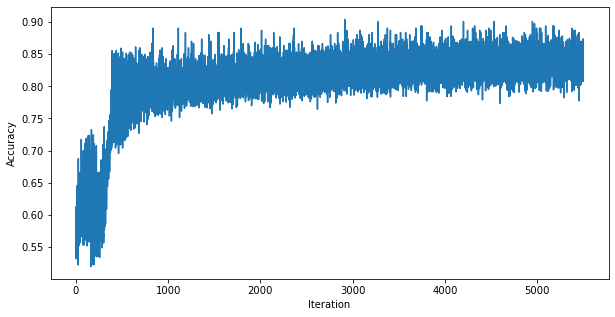

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

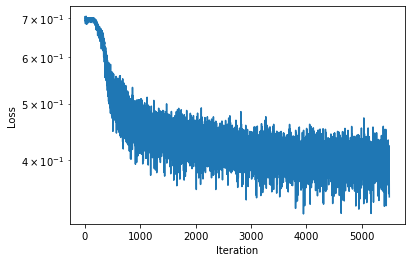

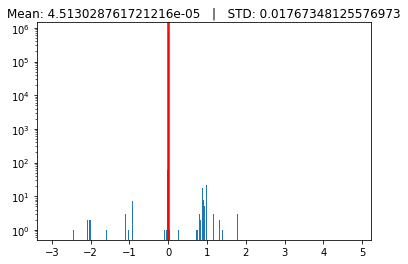

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 7.416666666666667


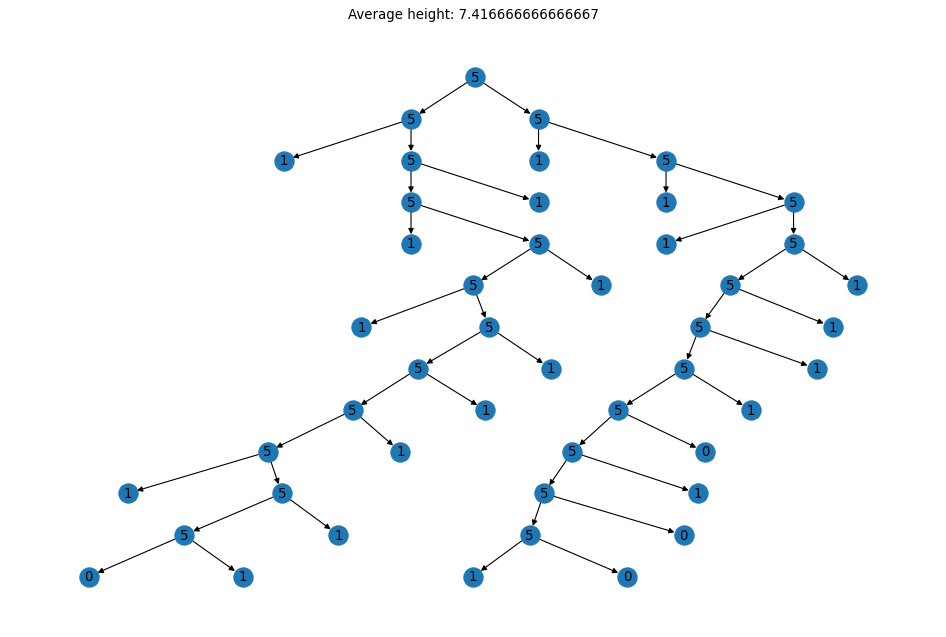

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 24


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
Average comprehensibility: 66.66666666666667


In [23]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

Accuracy: 0.8223032355308533


In [24]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

Sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1.0: 0.9723756906077348
layer 2.0: 0.9723756906077348
layer 3.0: 0.9723756906077348
layer 4.0: 0.9723756906077348
layer 5.0: 0.9723756906077348
layer 6.0: 0.9723756906077349
layer 7.0: 0.9723756906077345
layer 8.0: 0.9723756906077345
layer 9.0: 0.9723756906077345
layer 10.0: 0.9723756906077345


## Prune the weights

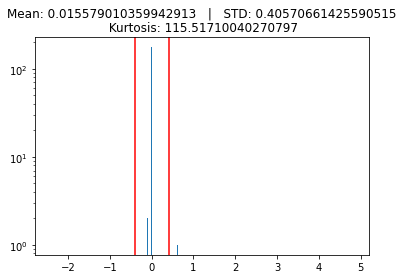

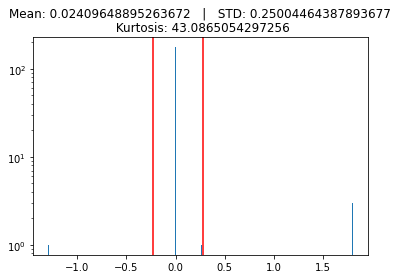

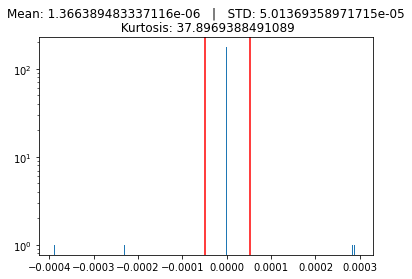

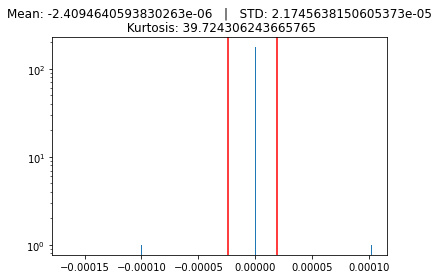

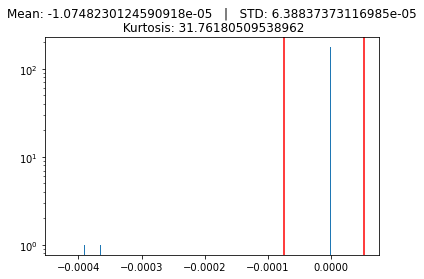

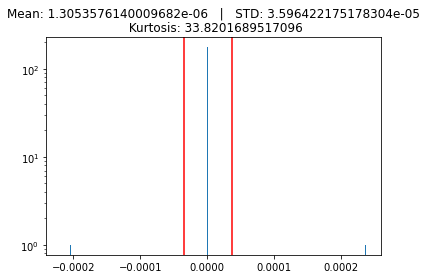

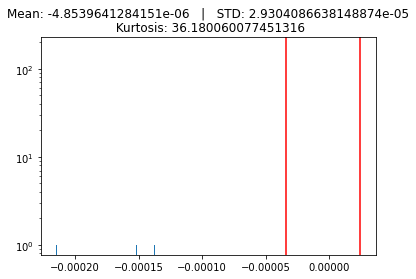

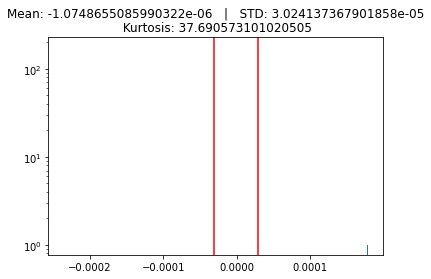

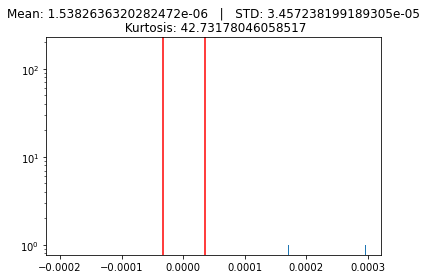

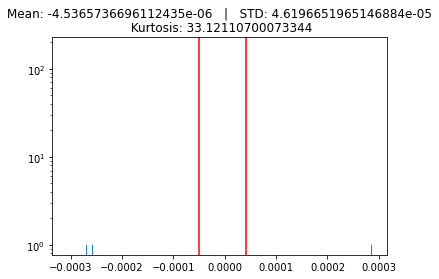

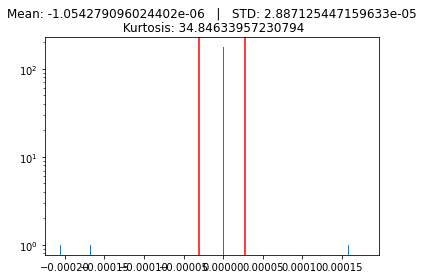

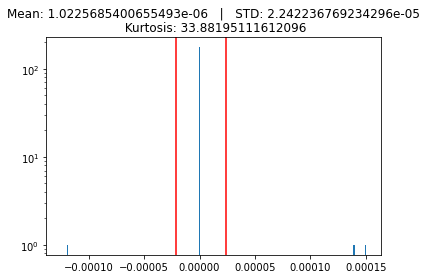

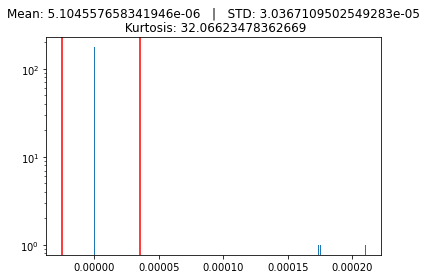

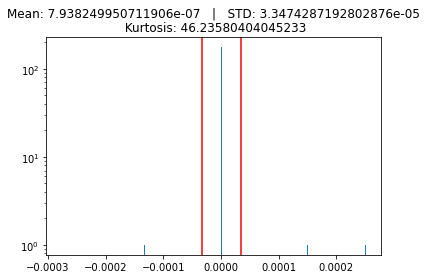

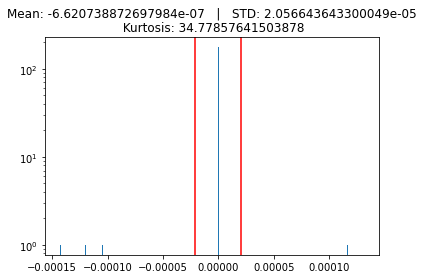

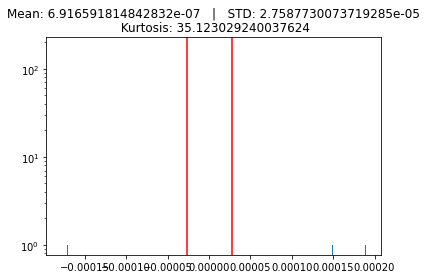

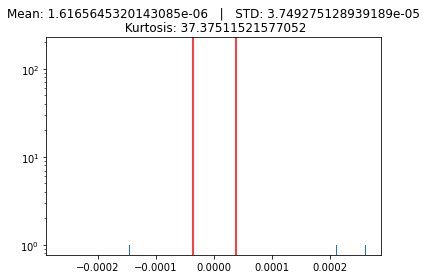

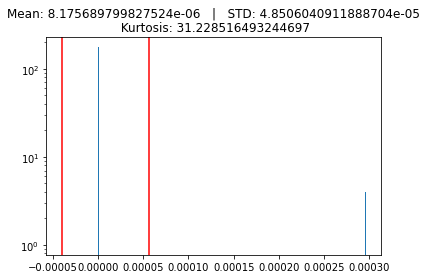

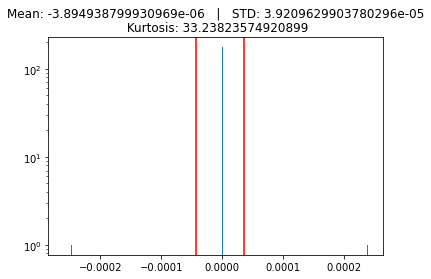

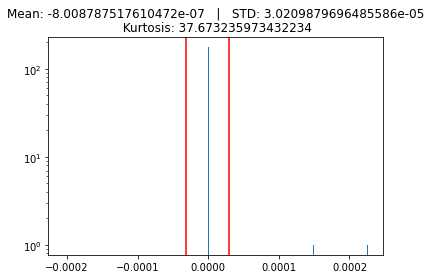

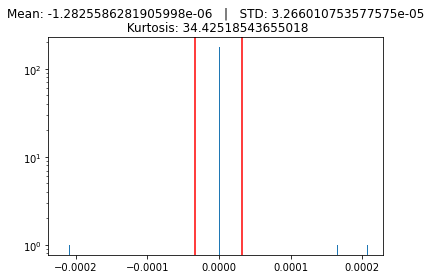

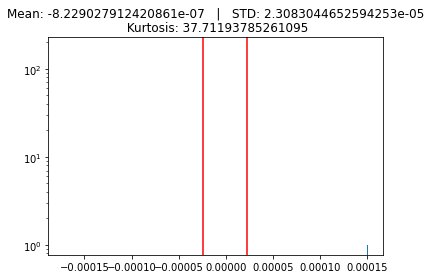

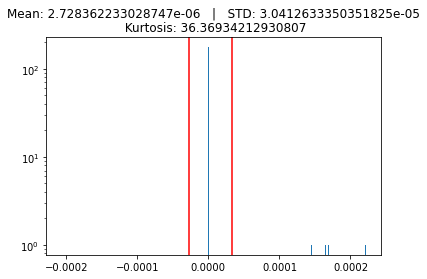

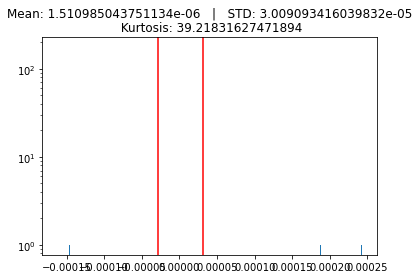

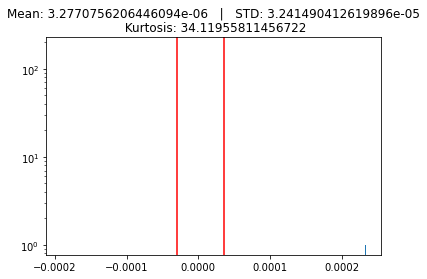

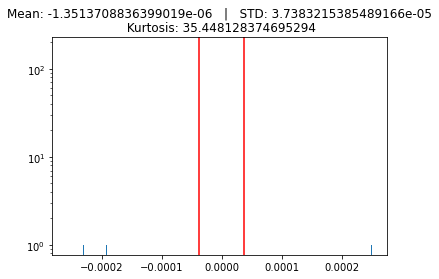

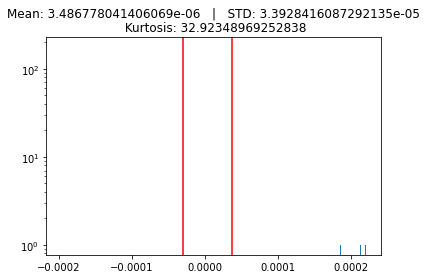

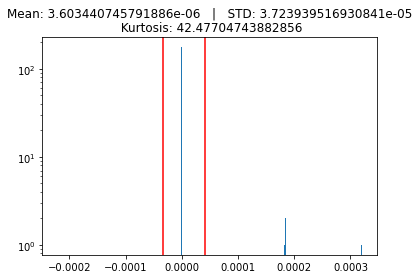

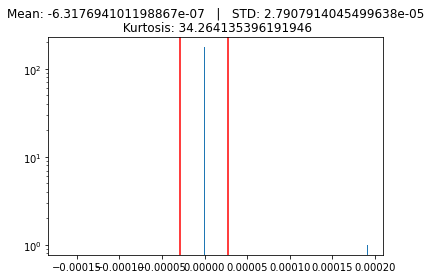

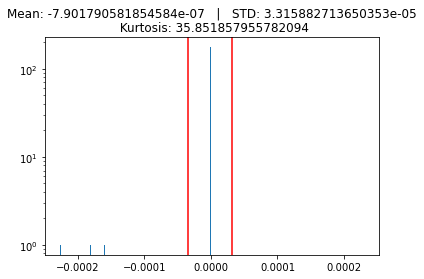

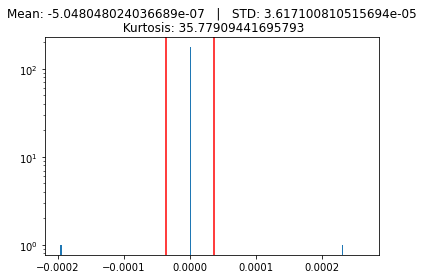

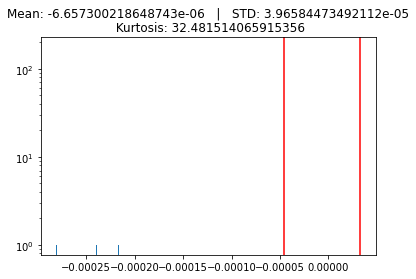

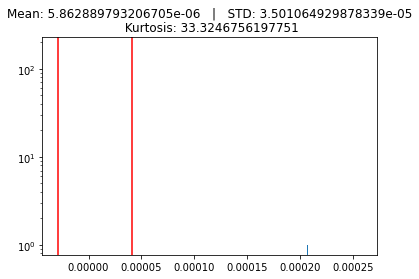

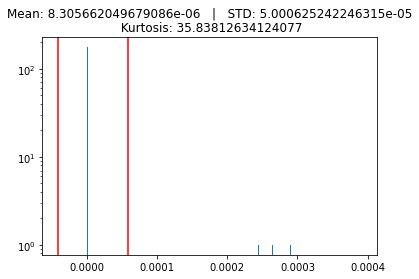

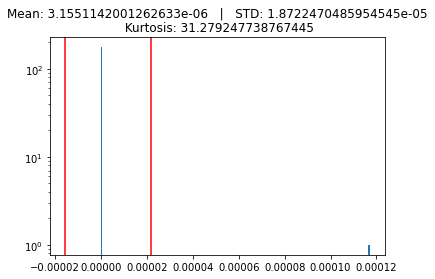

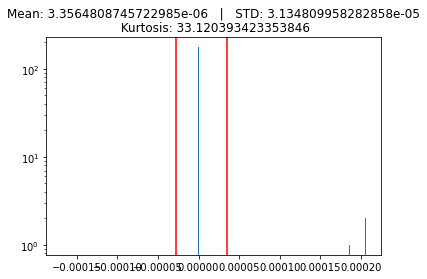

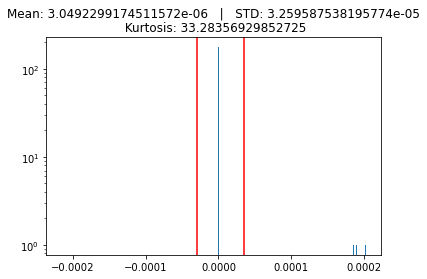

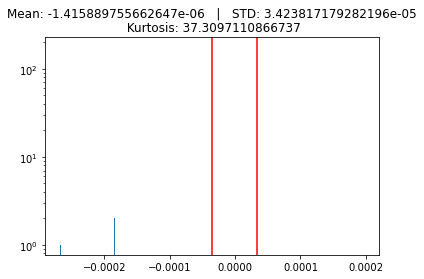

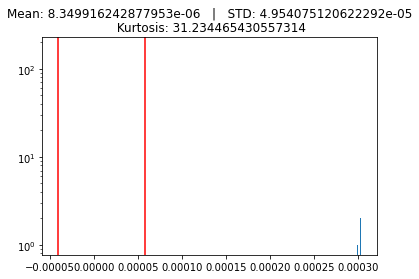

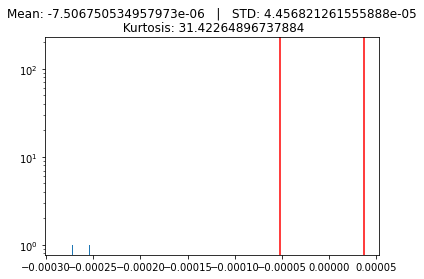

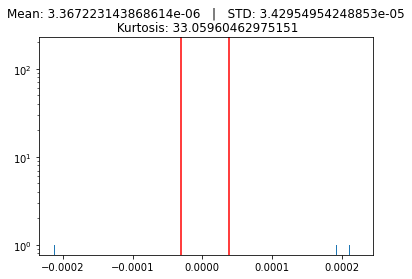

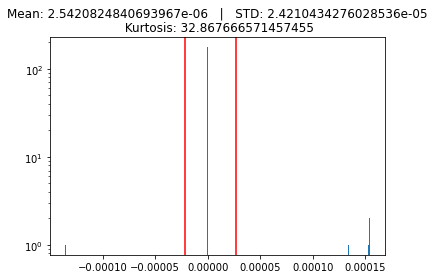

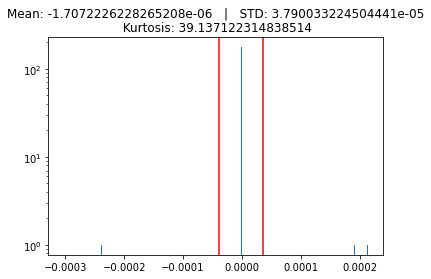

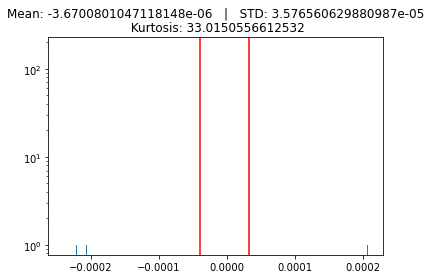

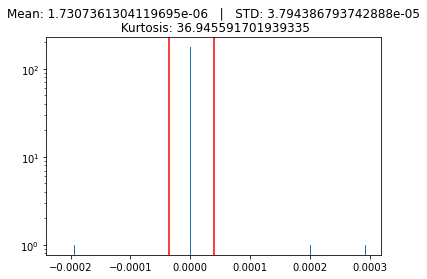

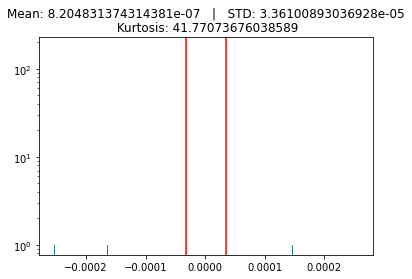

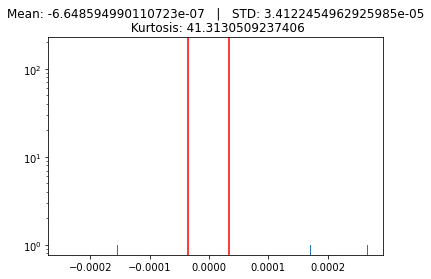

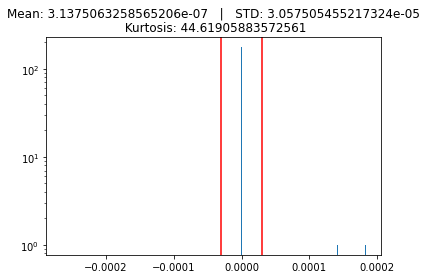

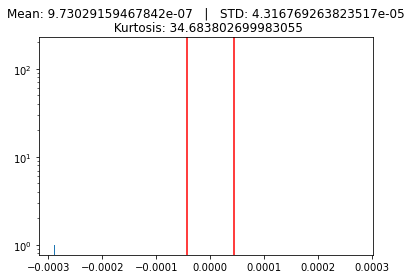

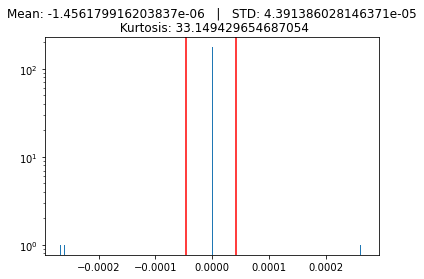

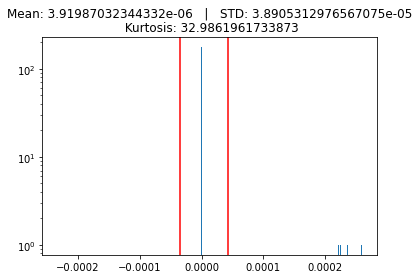

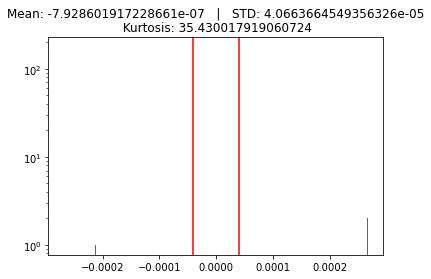

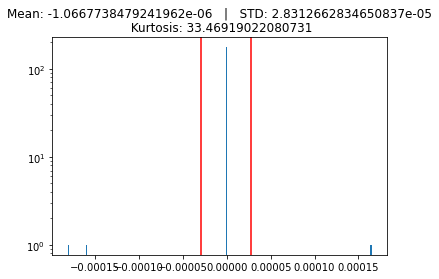

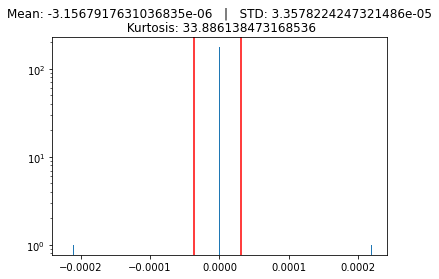

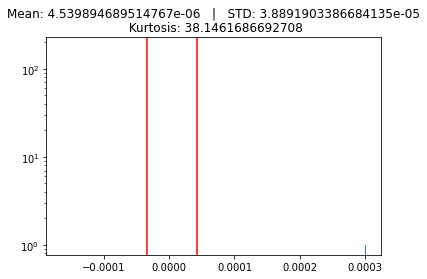

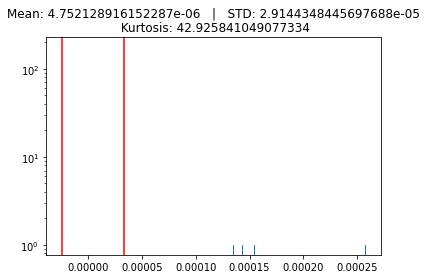

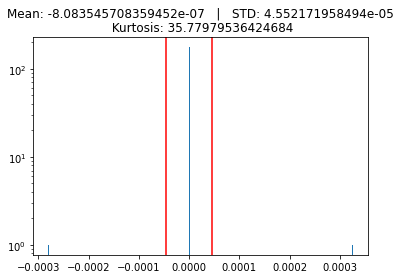

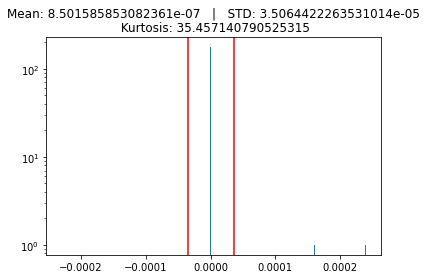

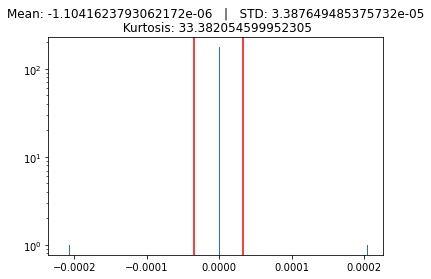

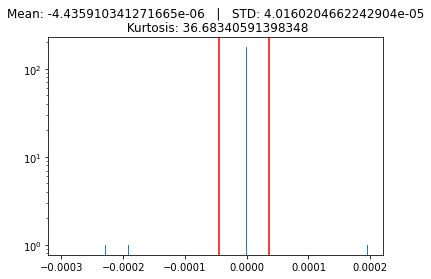

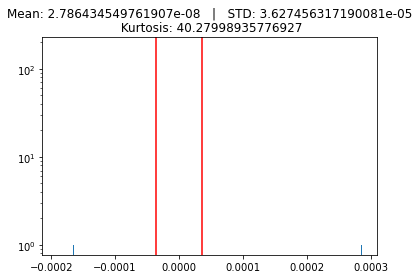

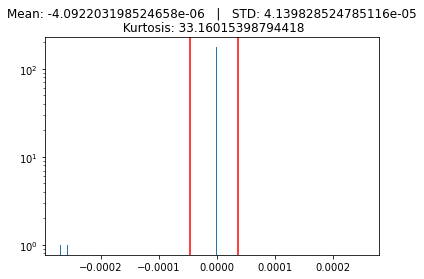

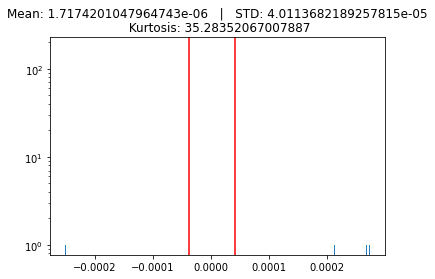

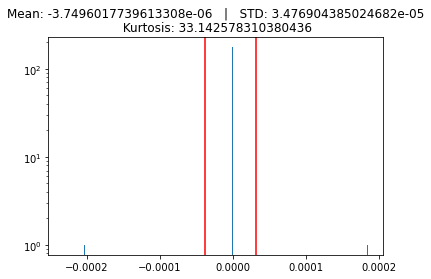

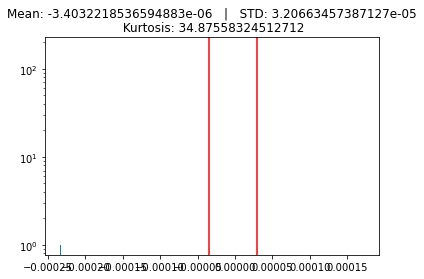

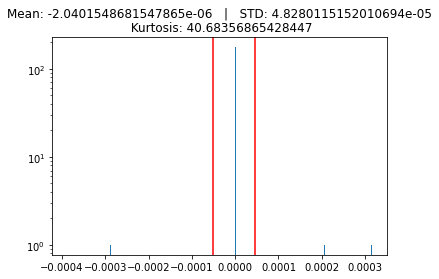

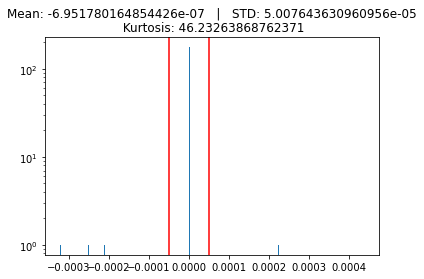

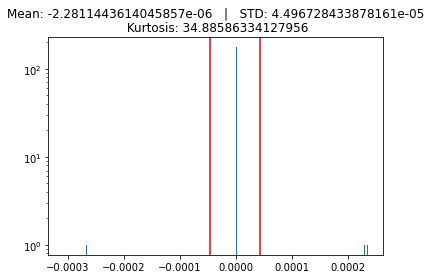

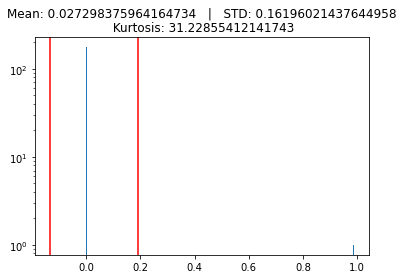

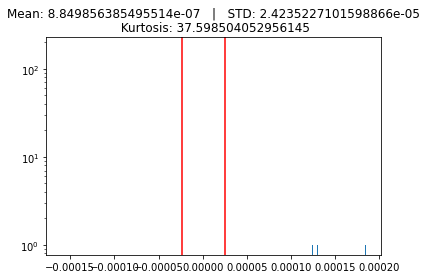

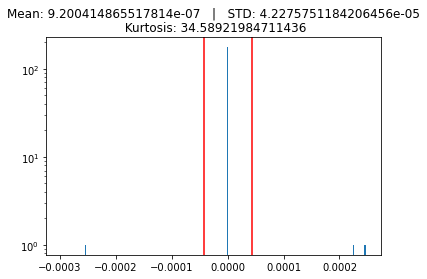

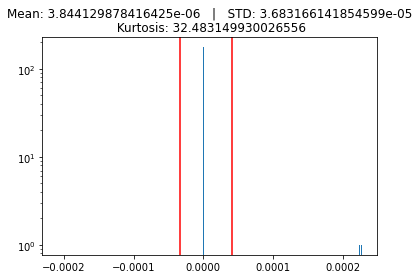

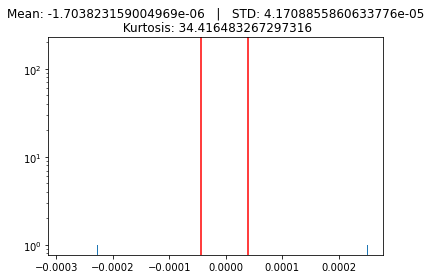

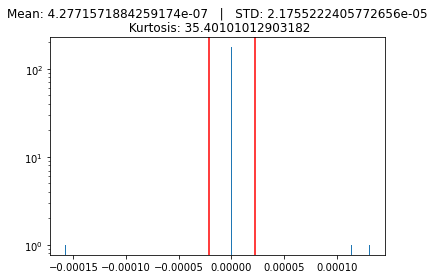

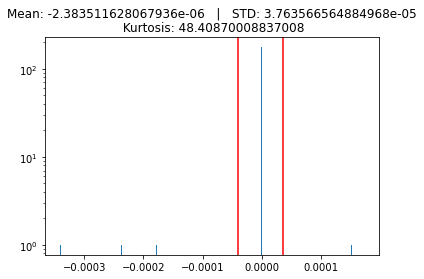

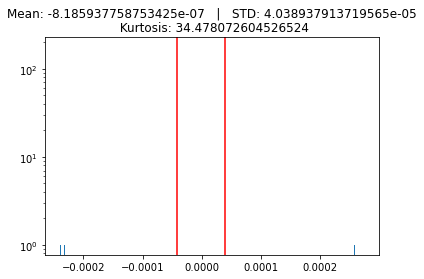

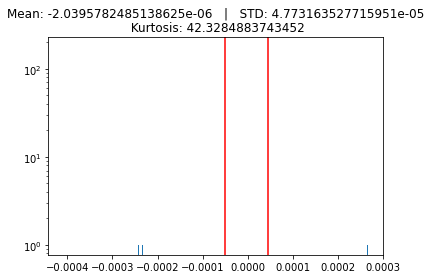

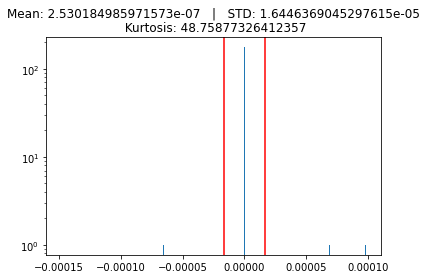

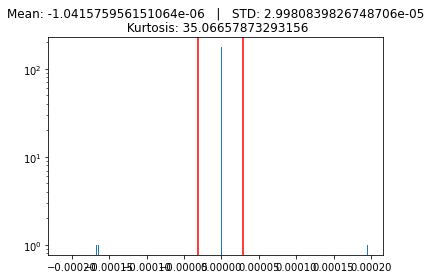

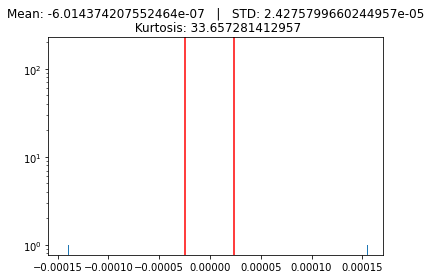

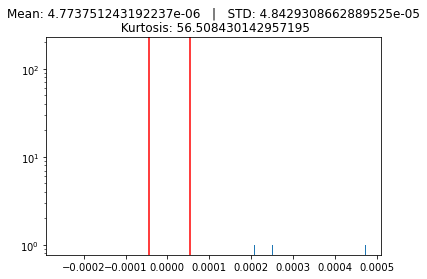

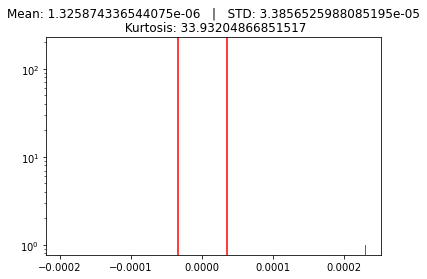

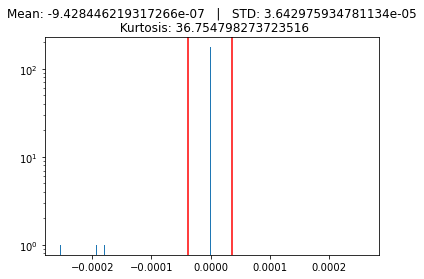

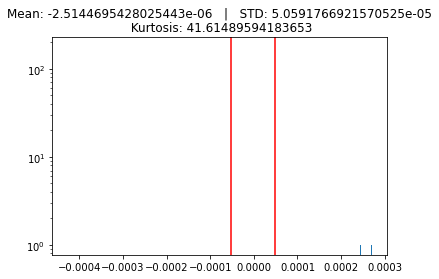

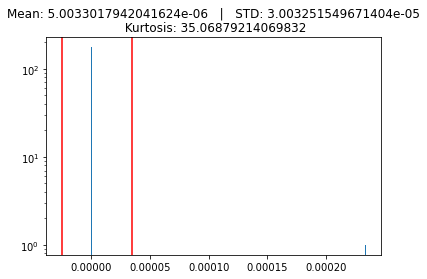

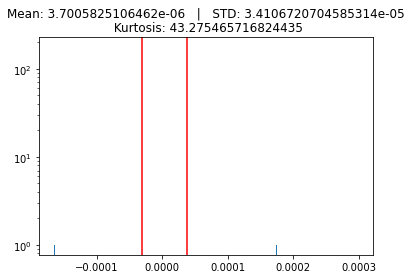

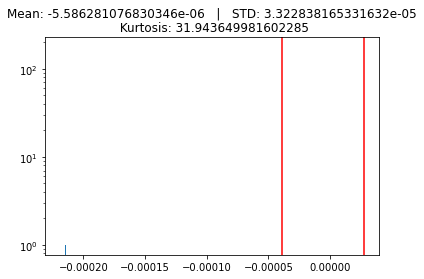

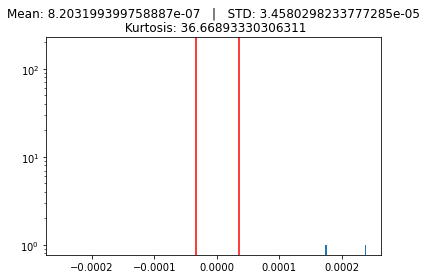

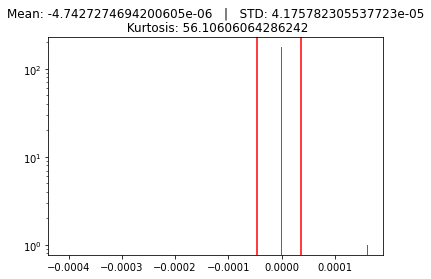

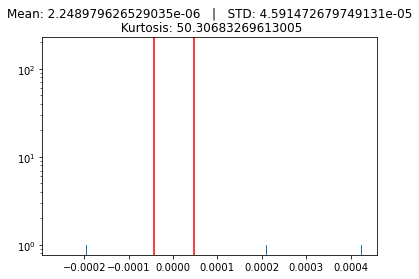

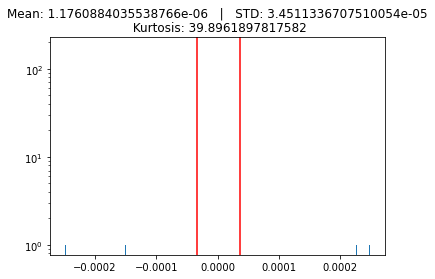

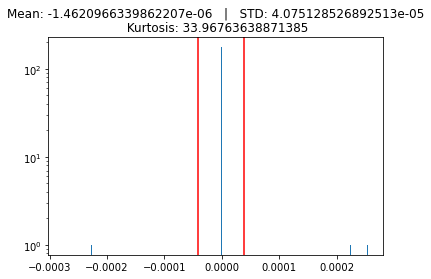

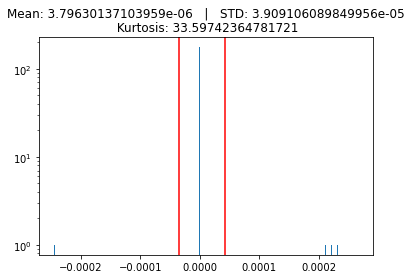

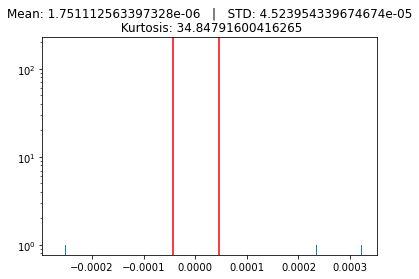

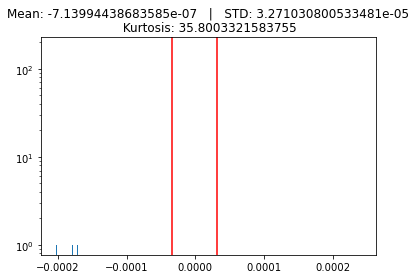

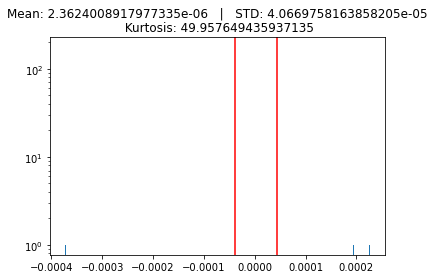

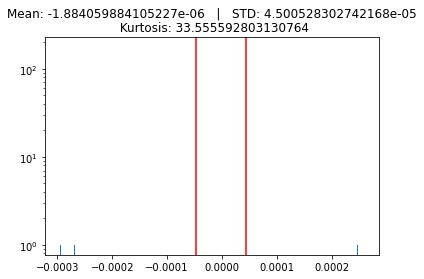

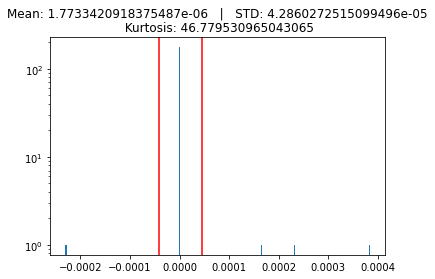

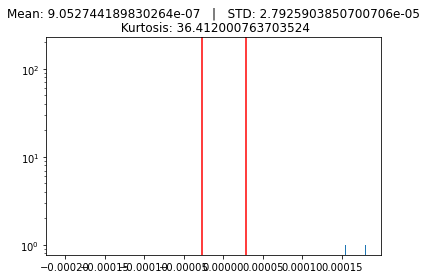

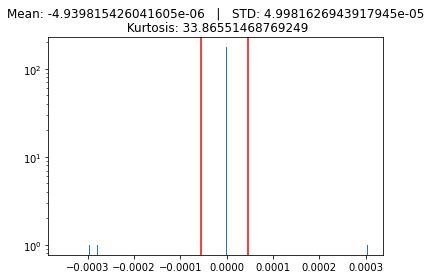

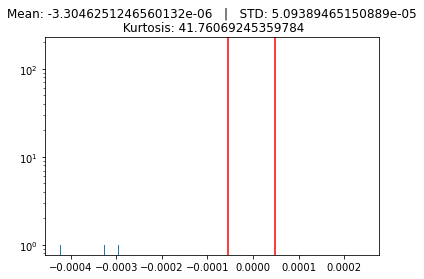

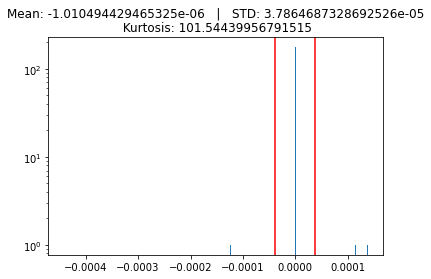

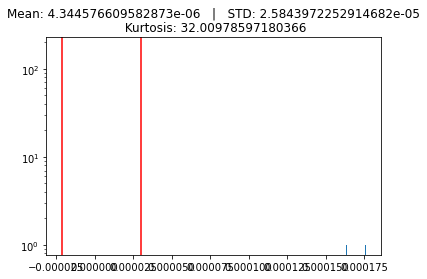

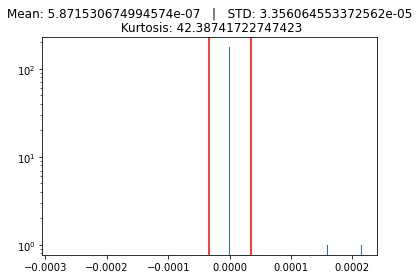

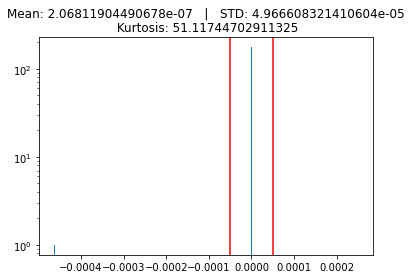

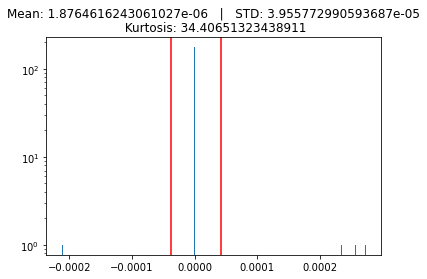

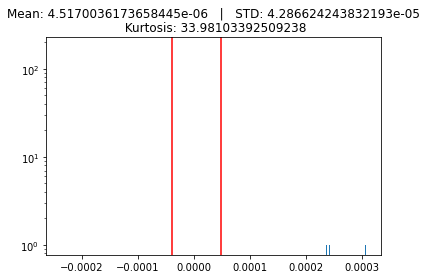

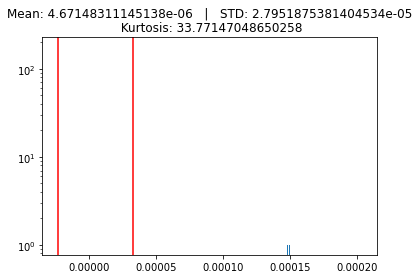

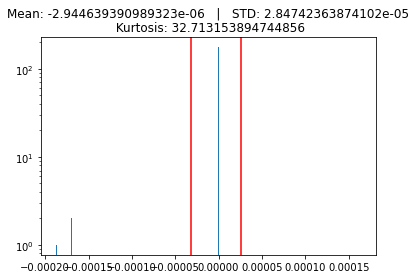

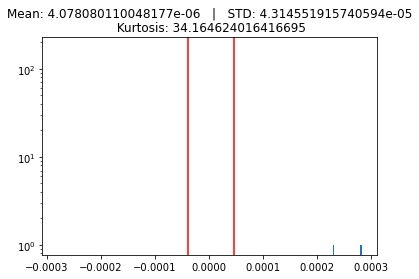

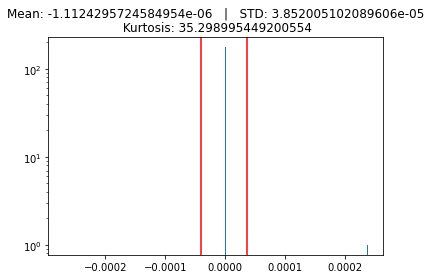

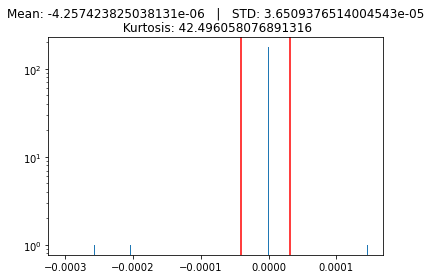

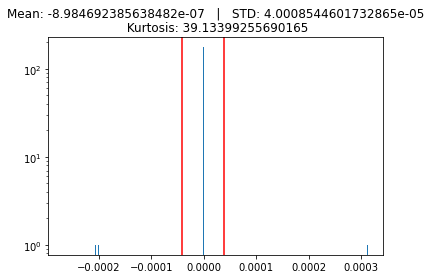

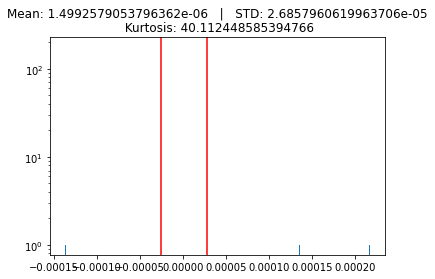

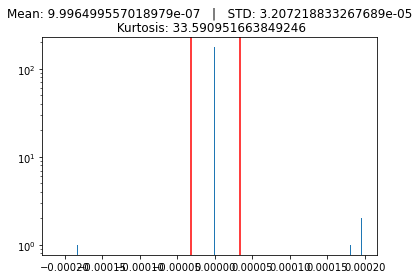

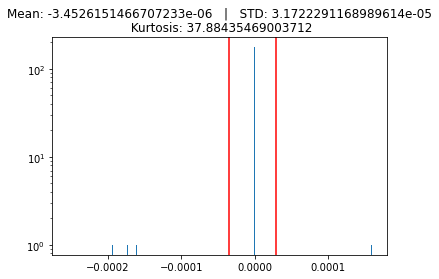

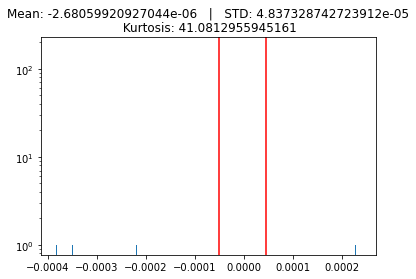

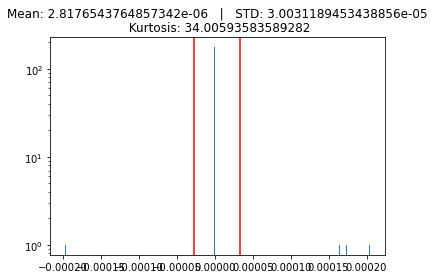

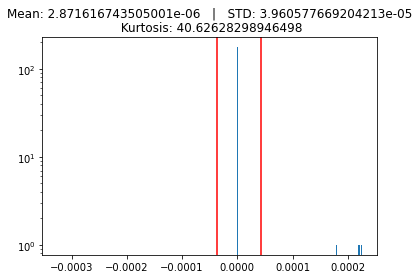

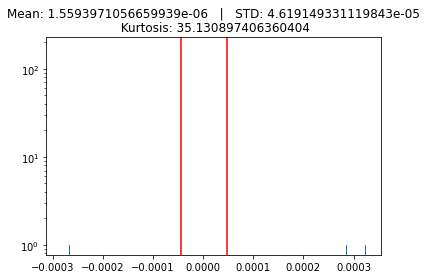

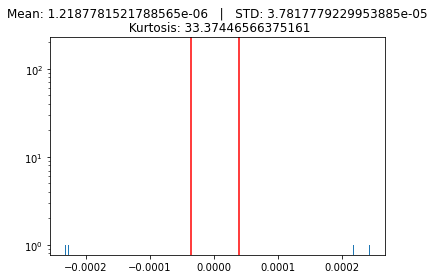

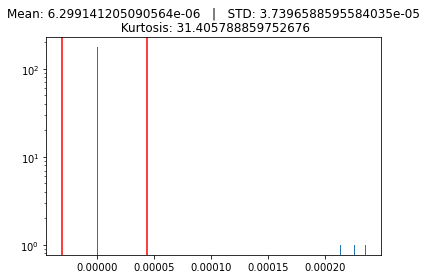

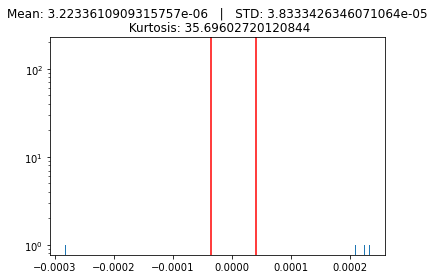

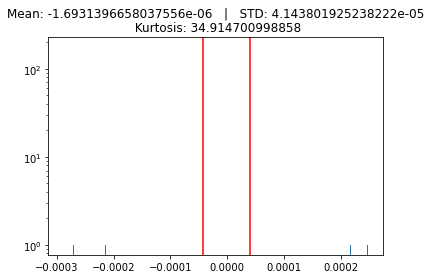

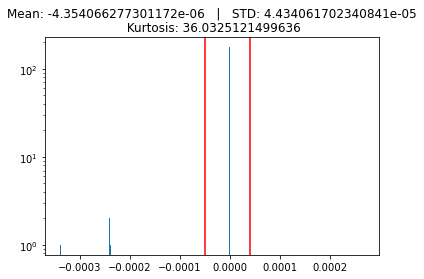

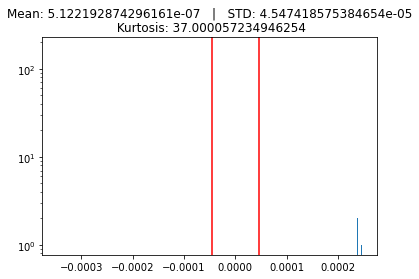

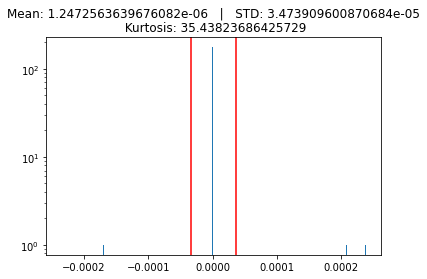

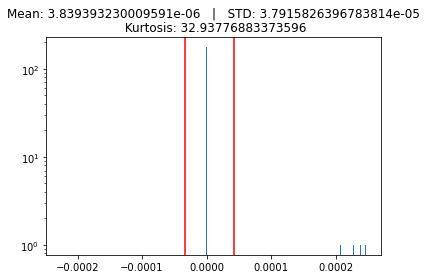

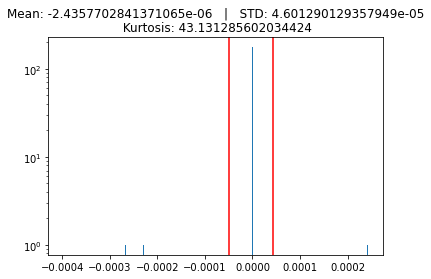

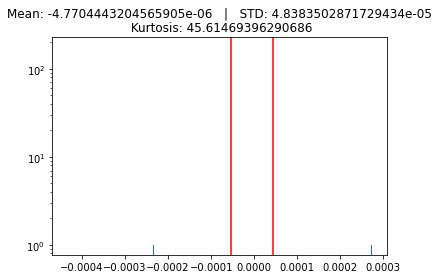

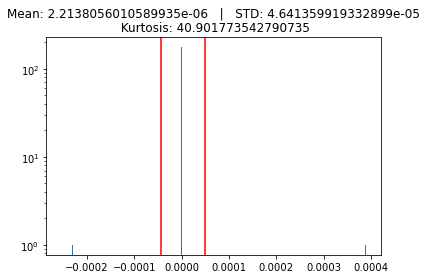

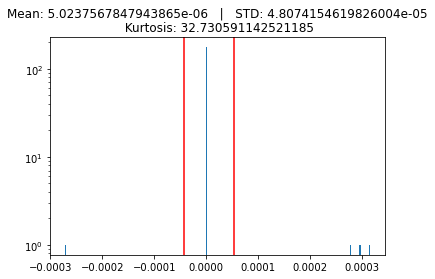

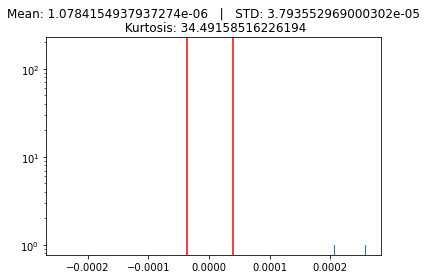

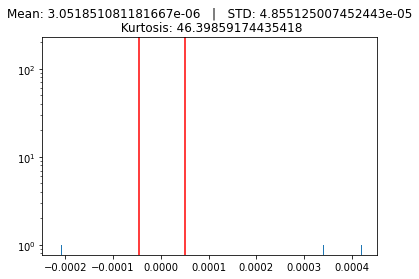

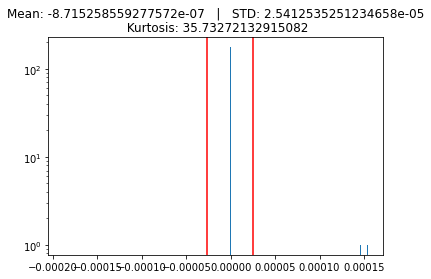

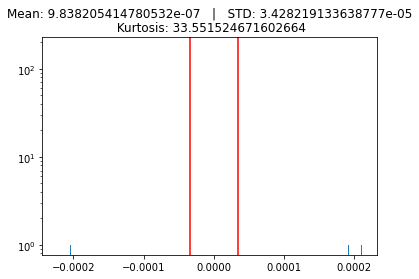

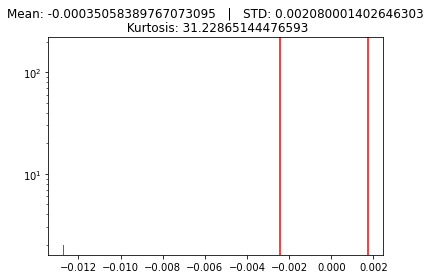

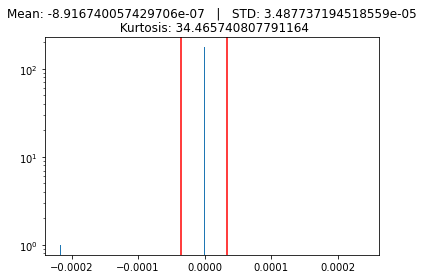

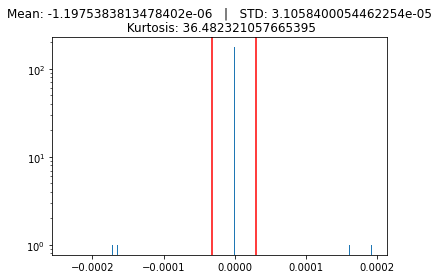

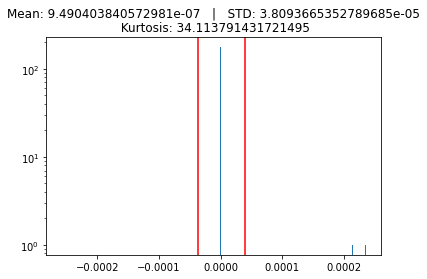

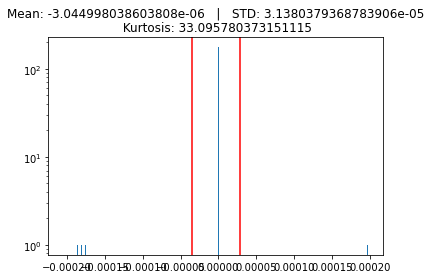

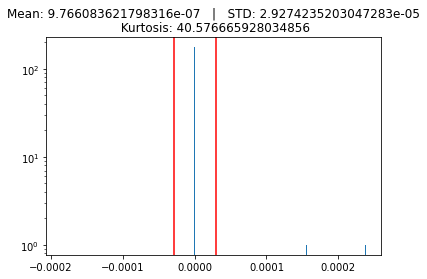

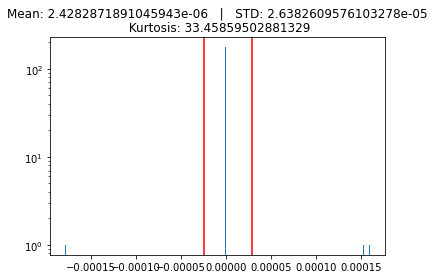

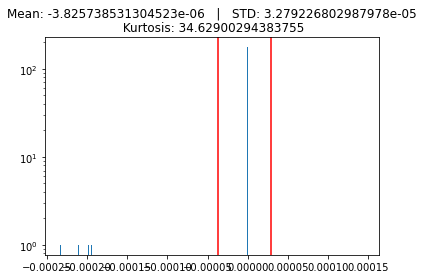

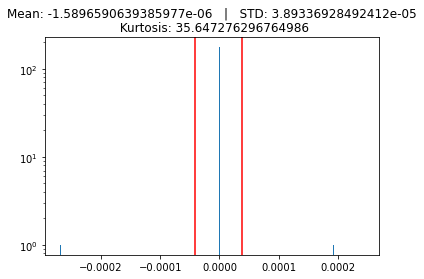

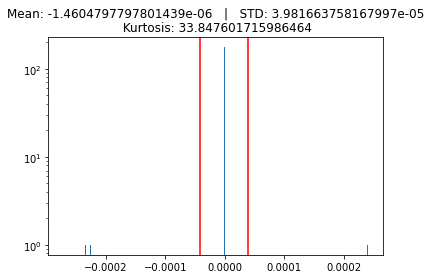

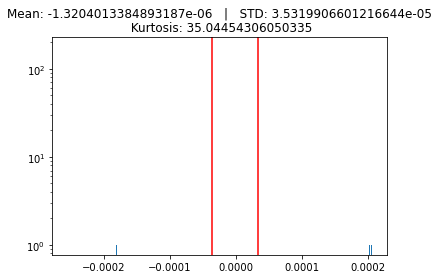

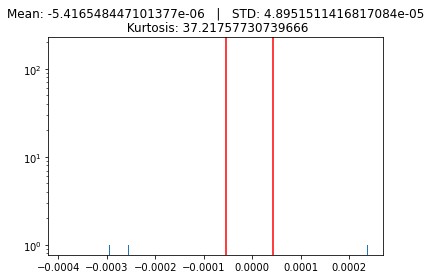

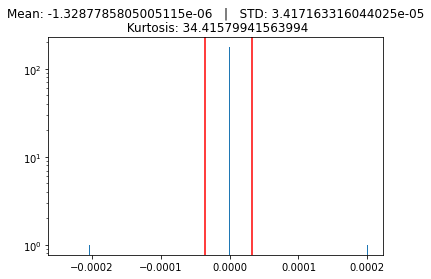

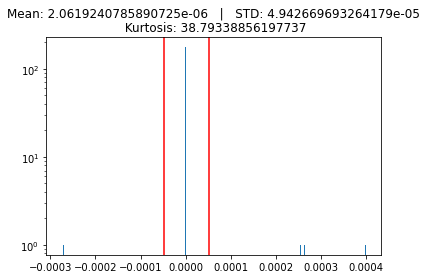

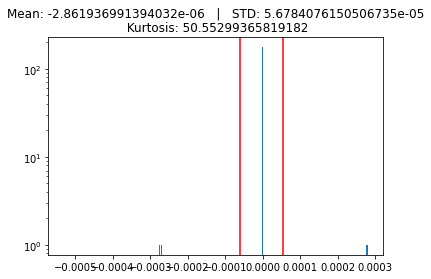

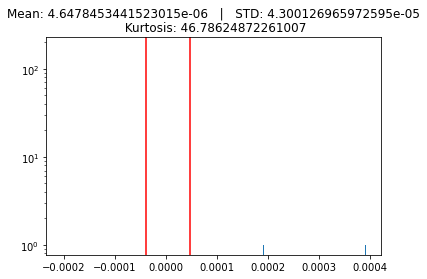

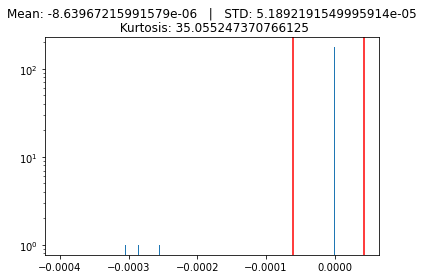

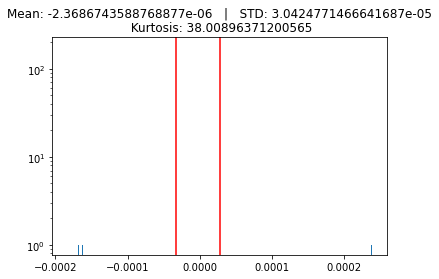

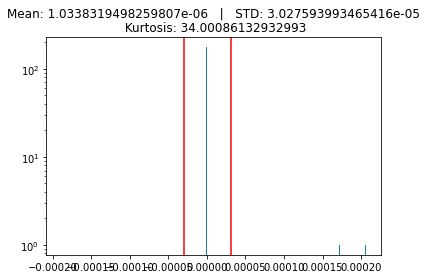

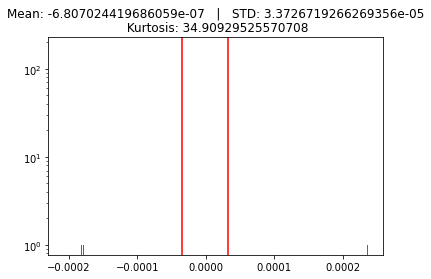

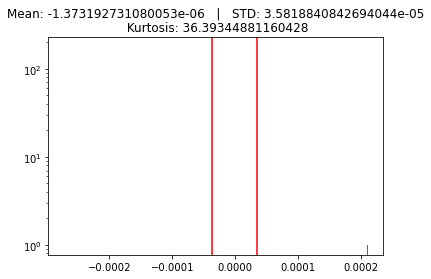

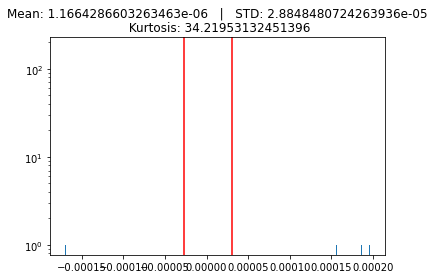

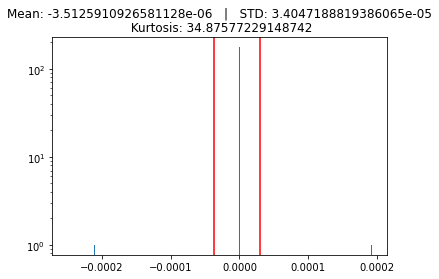

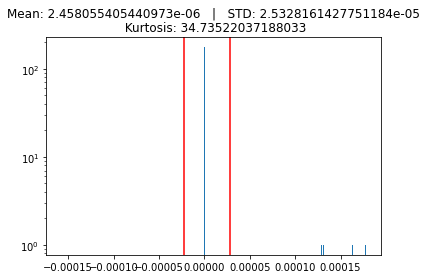

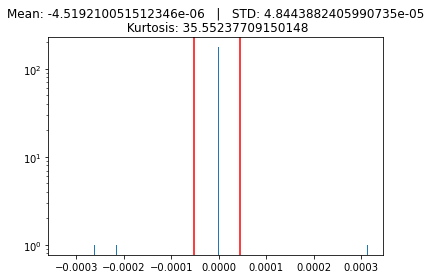

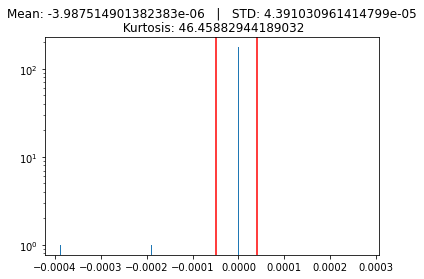

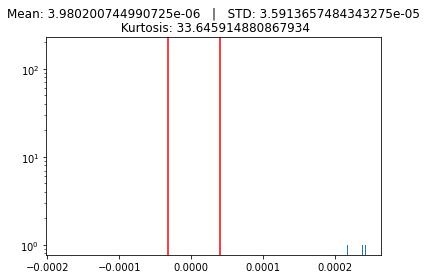

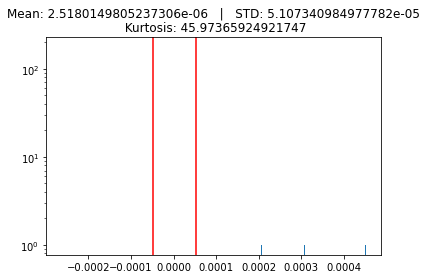

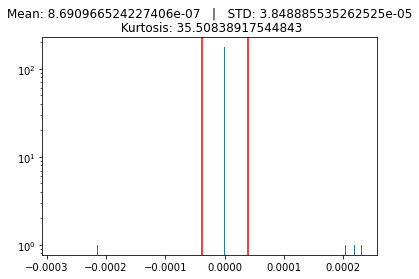

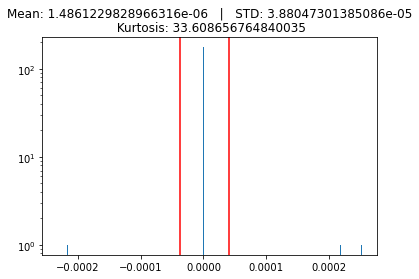

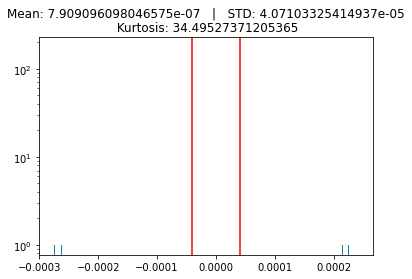

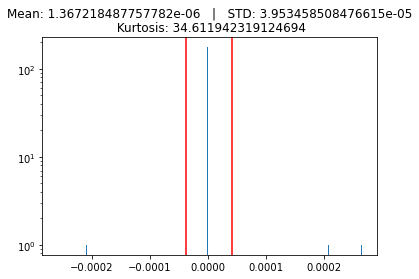

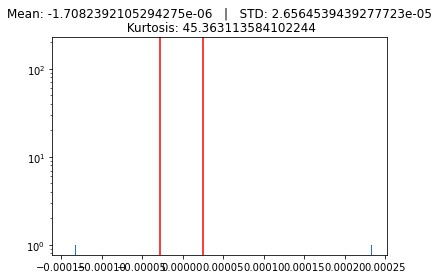

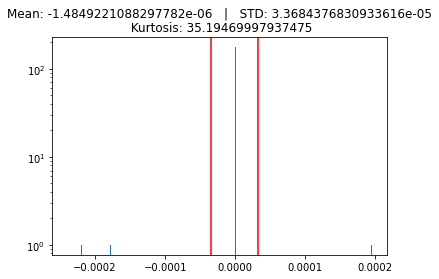

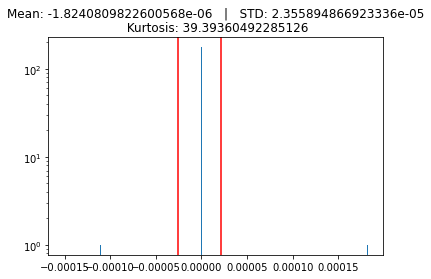

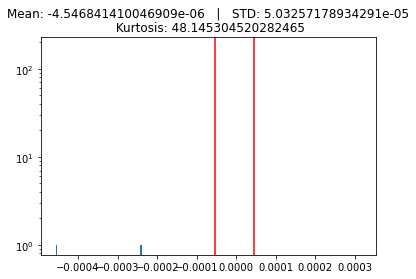

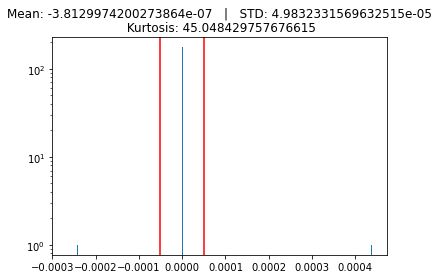

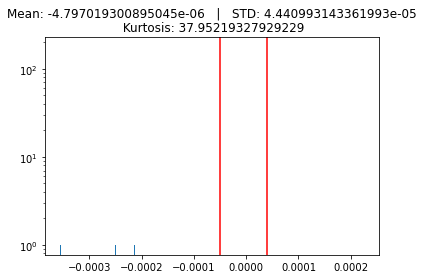

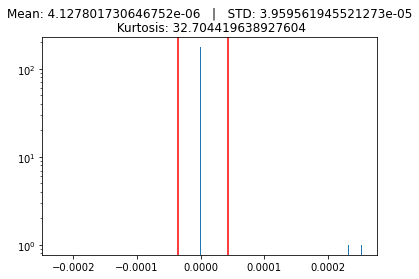

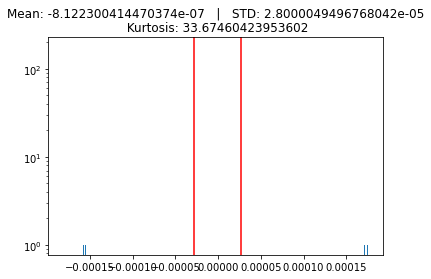

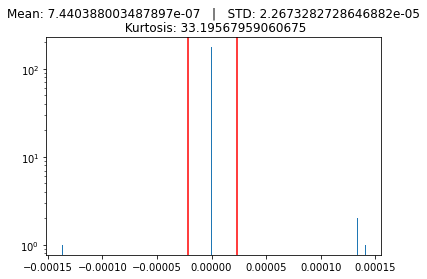

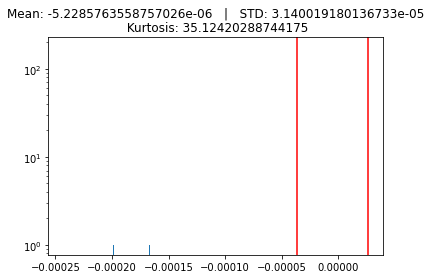

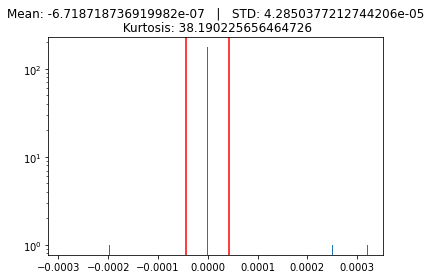

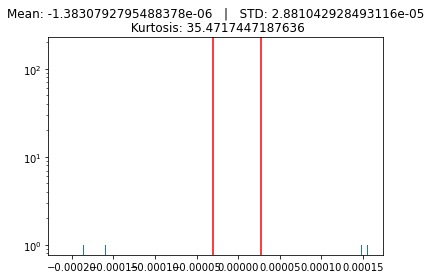

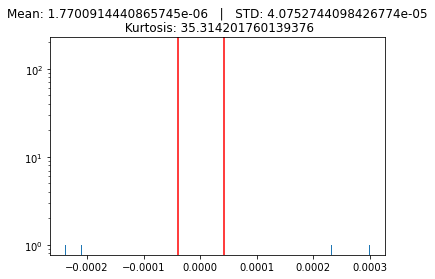

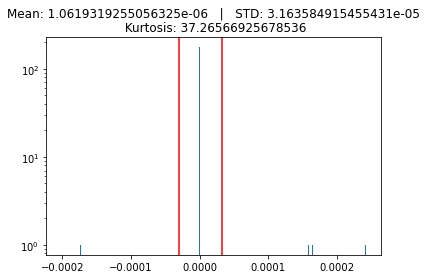

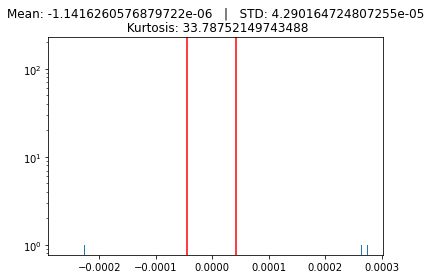

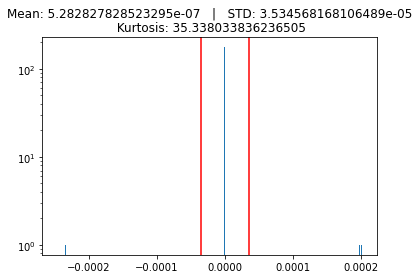

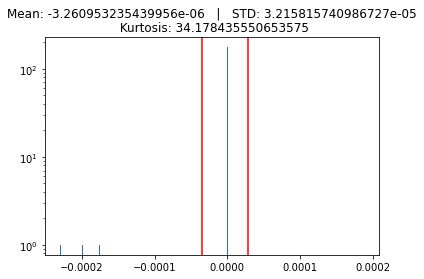

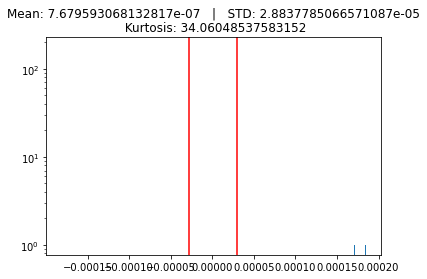

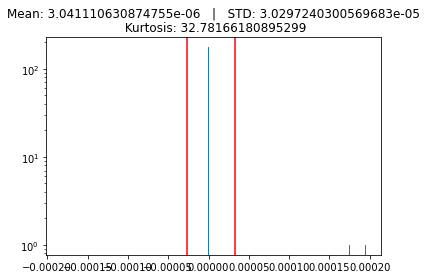

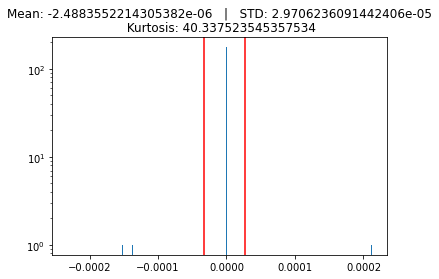

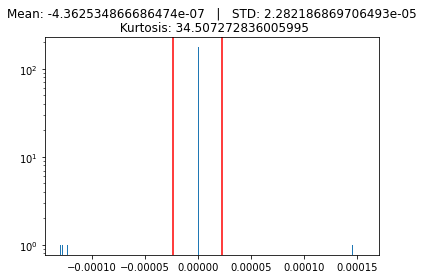

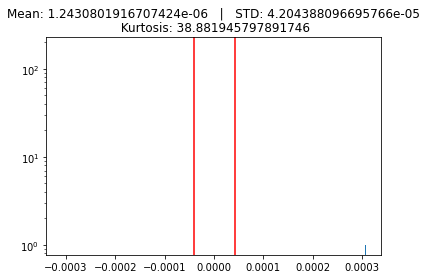

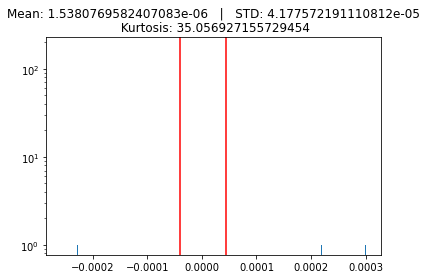

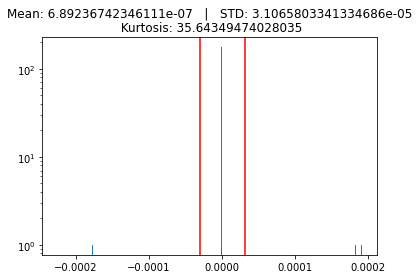

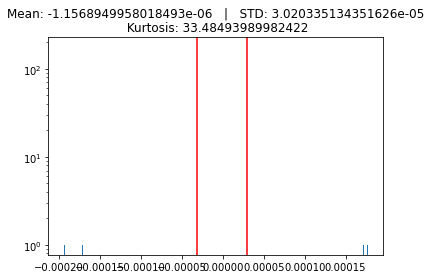

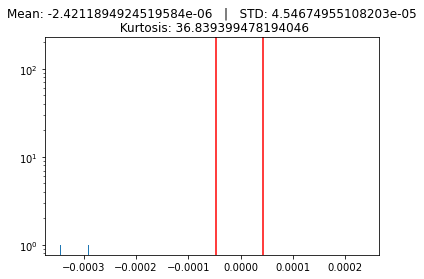

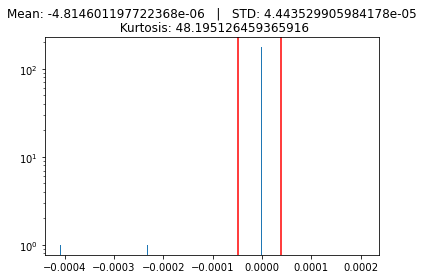

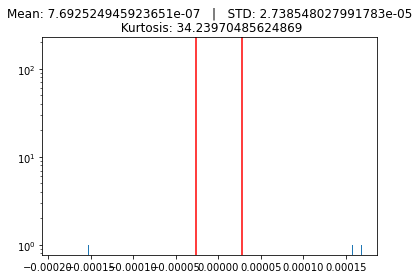

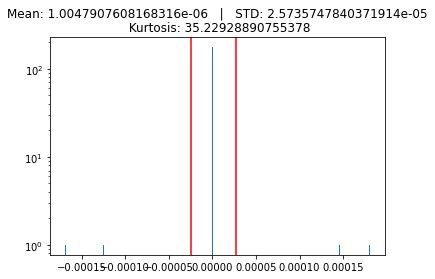

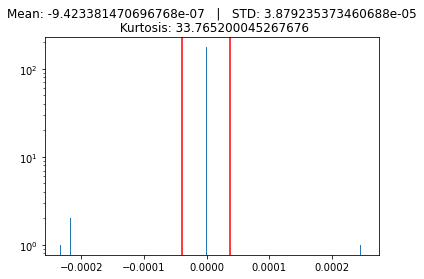

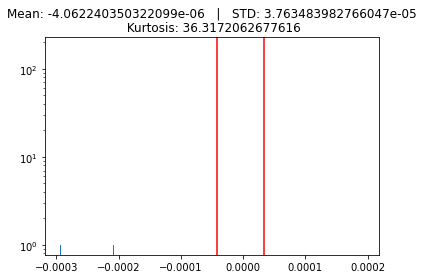

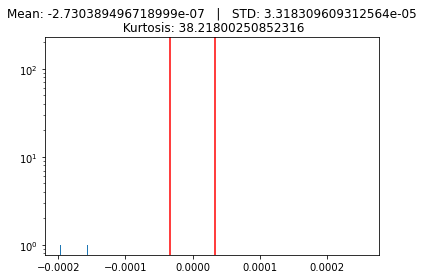

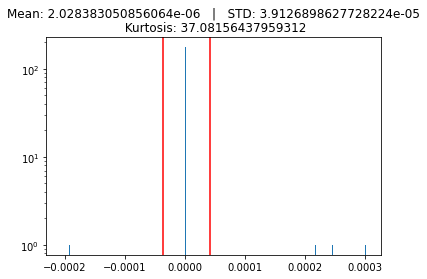

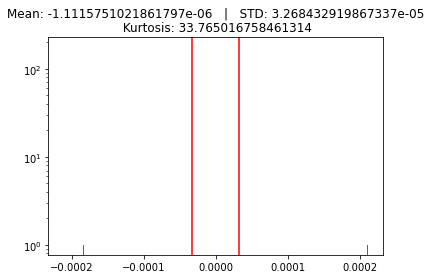

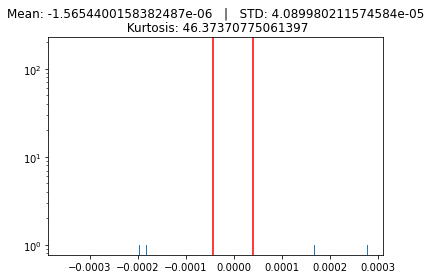

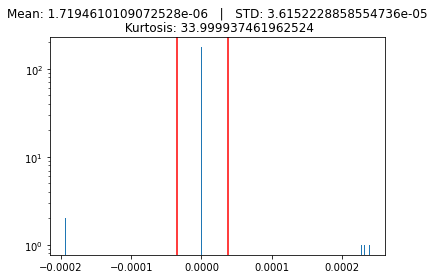

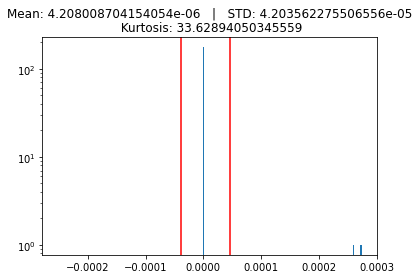

In [25]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [26]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


NameError: name 'tree_copy' is not defined

In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()